In [1]:
# Standard Library Imports
import os
import json

# Data Manipulation and Processing
import pandas as pd
import numpy as np
from pandas import json_normalize
from tqdm.notebook import tqdm

# Data Preprocessing

### Features:

user_id - for accounts with post data

Username Features
- username

    Engineered:
    - username_uppercase
    - username_lowercase
    - username_numeric
    - username_special
    - username_length
    - username_se

Screenname Features
- screenanme
    
    Engineered:
    - screenname_uppercase
    - screenname_lowercase
    - screenname_numeric
    - screenname_special
    - screenname_length
    - screenname_se
    - screenname_emoji
    - screenname_hashtag
    - screenname_word

Description Features
- description

    Engineered:
    - description_length
    - description_TFIDF (?)

User Metadata Features
- user_md_follower
- user_md_following
- user_md_follow_ratio
- user_md_total_post
- user_md_total_like
- user_md_verified
- user_md_protected

    Engineered:
    - user_md_follow_ratio
    - user_md_total_post
    - user_md_total_like

Post Metadata Features
- post_md_like
- post_md_retweet - turn into repost???
- post_md_reply
- post_md_quote - combine with retweet -> repost ???

    Engineered:
    - post_md_like_mean
    - post_md_like_std
    - post_md_retweet_mean
    - post_md_retweet_std
    - post_md_reply_mean
    - post_md_reply_std
    - post_md_quote_mean
    - post_md_quote_std

Post Text Features
- post_text

    Engineered:
    - post_text_length_mean
    - post_text_length_std
    - post_text_sentiment_score_mean
    - post_text_sentiment_score_std
    - post_text_sentiment_numeric_mean
    - post_text_sentiment_numeric_std
    - post_sentiment_numeric_prop_positive
    - post_sentiment_numeric_prop_negative

Label - must be BOOL

### Extraction Checklist:

**ASSUMING THAT FEATURE COLUMNS ARE ALREADY RENAMED**

Extract:
- user_id
- username
- screenname
- description
- user_md_follower
- user_md_following
- user_md_follow_ratio
- user_md_total_post
- user_md_total_like
- user_md_verified
- user_md_protected
- post_md_like
- post_md_retweet - turn into repost???
- post_md_reply
- post_md_quote - combine with retweet -> repost ???
- post_text


Create availability indicator for each subset
- if values were extracted, 1; else, 0

### Cleaning Checklist:

user_id
- ensure missing features are NaN
    - fillna(np.nan)

- convert to string
- strip()
- drop duplicates

username
- ensure missing features are NaN
    - fillna(np.nan)

- convert to string

- remove invalid characters **
    - data['username_cleaned'] = data['username'].apply(lambda x: re.sub(r'[^a-zA-Z0-9._]', '', x))
    
- after removing, if missing, replace with NaN
    - data['username_cleaned'] = data['username_cleaned'].replace('', np.nan)

- strip()

screenname
- ensure missing features are NaN
    - fillna(np.nan)

- convert to string

- remove invalid characters **

- after removing, if missing, replace with NaN
    - data['username_cleaned'] = data['username_cleaned'].replace('', np.nan)

- strip()

description
- ensure missing features are NaN
    - fillna(np.nan)

- convert to string

- lowercase

- strip()

user metadata
- ensure missing features are NaN
    - fillna(np.nan)

- numeric data
    - convert into numeric (1.5k -> 1500)

- convert into float

- binary values
    - convert into bool (0/1 -> FALSE/TRUE)

post metadata
- ensure missing features are NaN
    - fillna(np.nan)

- numeric data
    - convert into numeric (1.5k -> 1500)

- convert into float

post text
- strip()

### Engineering Checklist

- Username
    - username_uppercase (float)
    - username_lowercase (float)
    - username_numeric (float)
    - username_special (float)
    - username_length (float)
    - username_se (float)

- Screenname
    - screenname_uppercase (float)
    - screenname_lowercase (float)
    - screenname_numeric (float)
    - screenname_special (float)
    - screenname_length (float)
    - screenname_se (float)
    - screenname_emoji (float)
    - screenname_hashtag (float)
    - screenname_word (float)


- Description
    - description_length (float)

- User Metadata
    - user_md_follow_ratio (0 if either side is missing)

- Post Metadata **GROUP BY USER_ID**
    - post_md_like_mean (float)
    - post_md_like_std (float)
    - post_md_retweet_mean (float)
    - post_md_retweet_std (float)
    - post_md_reply_mean (float)
    - post_md_reply_std (float)
    - post_md_quote_mean (float)
    - post_md_quote_std (float)

- Post Text **GROUP BY USER_ID**
    - post_text_length_mean (float)
    - post_text_length_std (float)
    - post_text_sentiment_score_mean (float)
    - post_text_sentiment_score_std (float)
    - post_text_sentiment_numeric_mean (float)
    - post_text_sentiment_numeric_std (float)
    - post_sentiment_numeric_prop_positive (float)
    - post_sentiment_numeric_prop_negative (float)

# Code

## Import

In [1]:
# Standard Library Imports
import os
import json

# Data Manipulation and Processing
import pandas as pd
import numpy as np
import re
from pandas import json_normalize
from tqdm.notebook import tqdm

# Text Processing
import emoji
from transformers import RobertaTokenizer, RobertaForSequenceClassification, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation



# Machine Learning Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import joblib

# Statistical Utilities
from scipy.stats import mode

## Cleaning

### user features

In [114]:
df = pd.read_csv('../data/final/testing/from/testing_twibot-22_account.csv')

In [115]:
features = ['user_id', 'username', 'screenname', 'description', 'user_md_follower', 'user_md_following',
            'user_md_follow_ratio', 'user_md_total_post', 'user_md_total_like', 'user_md_verified', 'user_md_protected']

In [116]:
# user_id

# Fill missing values in user_id column with NaN
df['user_id'] = df['user_id'].fillna(pd.NA)

# Remove Duplicates
# Create a mask to identify rows with missing user_id
mask = df['user_id'].isnull()

# Drop duplicates from rows with non-missing user_id
df.loc[~mask] = df.loc[~mask].drop_duplicates(subset='user_id', keep='first')

# df['user_id'] = df['user_id'].apply(lambda x: str(x).strip() if pd.notnull(x) else x)

# df['user_id'] = df['user_id'].astype(str).str.strip()



# username

# Fill missing values in username column with NaN
df['username'] = df['username'].fillna(pd.NA)

# Convert into string type
df['username'] = df['username'].astype('string').str.strip()

# Function to clean the usernames and count modifications
def clean_username(username):
    if pd.isna(username):
        return username, False  # No modification needed for NaN
    cleaned_username = re.sub(r'[^a-zA-Z0-9._]', '', username)
    if cleaned_username == '':
        return pd.NA, True  # Return NaN if the username became empty
    return cleaned_username, cleaned_username != username  # Return cleaned username and whether modification occurred

# Apply cleaning and track modifications
modified_count = 0
df['username_cleaned'], df['modified'] = zip(*df['username'].apply(lambda x: clean_username(x)))

# Count how many usernames were modified
modified_count = df['modified'].sum()

df['username'] = df['username_cleaned'].astype('string').str.strip()

df = df.drop(columns=['modified', 'username_cleaned'])

# # Display how many usernames were modified
# print(f"Total modified usernames: {modified_count}")



# screenname

# Fill missing values in username column with NaN
df['screenname'] = df['screenname'] = df['screenname'].fillna(pd.NA)

# Convert into string type
df['screenname'] = df['screenname'].astype('string').str.strip()



# screenname

# Fill missing values in description column with NaN
df['description'] = df['description'].fillna(pd.NA)

# Convert to string type and strip whitespace
df['description'] = df['description'].astype('string').str.strip()

# Convert to lowercase
df['description'] = df['description'].str.lower()



# user_md

# Fill missing values
df['user_md_follower'] = df['user_md_follower'].fillna(pd.NA)
df['user_md_following'] = df['user_md_following'].fillna(pd.NA)
df['user_md_follow_ratio'] = df['user_md_follow_ratio'].fillna(pd.NA)
df['user_md_total_post'] = df['user_md_total_post'].fillna(pd.NA)
df['user_md_total_like'] = df['user_md_total_like'].fillna(pd.NA)
df['user_md_verified'] = df['user_md_verified'].fillna(pd.NA)
df['user_md_protected'] = df['user_md_protected'].fillna(pd.NA)

# Consistent Boolean Values
df['user_md_verified'] = df['user_md_verified'].replace({'yes': True, 'no': False, 1: True, 0: False, 'True': True, 'False': False})
df['user_md_protected'] = df['user_md_protected'].replace({'yes': True, 'no': False, 1: True, 0: False, 'True': True, 'False': False})
# df['label'] = df['label'].replace({'yes': True, 'no': False, 1: True, 0: False, 'True': True, 'False': False})

# Convert types
df['user_md_follower'] = df['user_md_follower'].astype('Float64')
df['user_md_following'] = df['user_md_following'].astype('Float64')
df['user_md_follow_ratio'] = df['user_md_follow_ratio'].astype('Float64')
df['user_md_total_post'] = df['user_md_total_post'].astype('Float64')
df['user_md_total_like'] = df['user_md_total_like'].astype('Float64')
df['user_md_verified'] = df['user_md_verified'].astype('boolean')
df['user_md_protected'] = df['user_md_protected'].astype('boolean')
# df['label'] = df['label'].astype('boolean')

# Convert negative values
df['user_md_follower'] = df['user_md_follower'].clip(lower=0)
df['user_md_following'] = df['user_md_following'].clip(lower=0)
df['user_md_follow_ratio'] = df['user_md_follow_ratio'].clip(lower=0)
df['user_md_total_post'] = df['user_md_total_post'].clip(lower=0)
df['user_md_total_like'] = df['user_md_total_like'].clip(lower=0)



print (df.dtypes)

Unnamed: 0                       int64
user_id                         object
username                string[python]
username_uppercase               int64
username_lowercase               int64
username_numeric                 int64
username_special                 int64
username_length                  int64
username_se                    float64
screenname              string[python]
screenname_uppercase             int64
screenname_lowercase             int64
screenname_numeric               int64
screenname_special               int64
screenname_length                int64
screenname_se                  float64
screenname_emoji                 int64
screenname_hashtag               int64
screenname_word                  int64
description             string[python]
description_length               int64
user_md_follower               Float64
user_md_following              Float64
user_md_follow_ratio           Float64
user_md_total_post             Float64
user_md_total_like       

In [117]:
# OUTPUT FILE PATH
df.to_parquet('../data/final/testing/from/cleaned_testing_twibot-22_account.parquet', index=False)
df.to_csv('../data/final/testing/from/cleaned_testing_twibot-22_account.csv', index=False)


### Post Metadata and Text

In [119]:
# LOAD DATA
post_df = pd.read_csv('../data/final/testing/from/testing_twibot-22_tweets.csv', low_memory=False)

post_df = post_df.drop(columns=['Unnamed: 0'])

post_df = post_df.sort_values(by='username')

print (post_df)

                    user_id         username  post_md_like  post_md_retweet  \
53762  u1290789185058566144        07Mestiza             2                1   
52998  u1290789185058566144        07Mestiza             0             6545   
53248  u1290789185058566144        07Mestiza             0              182   
22867  u1290789185058566144        07Mestiza             2                1   
58692  u1290789185058566144        07Mestiza             0              251   
...                     ...              ...           ...              ...   
55489  u1371483467003785222  ziiiiiiiiiiiira             1                0   
15031  u1371483467003785222  ziiiiiiiiiiiira             1                0   
48275  u1371483467003785222  ziiiiiiiiiiiira             1                0   
14626  u1371483467003785222  ziiiiiiiiiiiira             1                0   
10307             u97841474           zumVIP             0                0   

       post_md_reply  post_md_quote  \
53762       

In [120]:
# Fill missing values
post_df['post_md_like'] = post_df['post_md_like'].fillna(pd.NA)
post_df['post_md_retweet'] = post_df['post_md_retweet'].fillna(pd.NA)
post_df['post_md_reply'] = post_df['post_md_reply'].fillna(pd.NA)
post_df['post_md_quote'] = post_df['post_md_quote'].fillna(pd.NA)
post_df['post_text'] = post_df['post_text'].fillna(pd.NA)

# Convert types
post_df['post_md_like'] = post_df['post_md_like'].astype('Float64')
post_df['post_md_retweet'] = post_df['post_md_retweet'].astype('Float64')
post_df['post_md_reply'] = post_df['post_md_reply'].astype('Float64')
post_df['post_md_quote'] = post_df['post_md_quote'].astype('Float64')
post_df['post_text'] = post_df['post_text'].astype('string').str.strip()

print (post_df.dtypes)

user_id                     object
username                    object
post_md_like               Float64
post_md_retweet            Float64
post_md_reply              Float64
post_md_quote              Float64
post_text           string[python]
post_text_length             int64
dtype: object


In [121]:
# OUTPUT FILE PATH
post_df.to_parquet('../data/final/testing/from/cleaned_testing_twibot-22_posts.parquet', index=False)
post_df.to_csv('../data/final/testing/from/cleaned_testing_twibot-22_posts.csv', index=False)

## Feature Engineering

In [136]:
# LOAD DATA

# df = pd.read_parquet('../data/final/testing/from/cleaned_testing_twibot-22_account.parquet')
df_text = pd.read_parquet('../data/final/testing/from/cleaned_testing_twibot-22_posts.parquet')

# print (df.dtypes)

# print (df_text.dtypes)

In [124]:
print (df.columns)

df = df.drop(columns=['Unnamed: 0'])

Index(['Unnamed: 0', 'user_id', 'username', 'username_uppercase',
       'username_lowercase', 'username_numeric', 'username_special',
       'username_length', 'username_se', 'screenname', 'screenname_uppercase',
       'screenname_lowercase', 'screenname_numeric', 'screenname_special',
       'screenname_length', 'screenname_se', 'screenname_emoji',
       'screenname_hashtag', 'screenname_word', 'description',
       'description_length', 'user_md_follower', 'user_md_following',
       'user_md_follow_ratio', 'user_md_total_post', 'user_md_total_like',
       'user_md_verified', 'user_md_protected', 'label'],
      dtype='object')


In [126]:
print (df.dtypes)

user_id                         object
username                string[python]
username_uppercase               int64
username_lowercase               int64
username_numeric                 int64
username_special                 int64
username_length                  int64
username_se                    float64
screenname              string[python]
screenname_uppercase             int64
screenname_lowercase             int64
screenname_numeric               int64
screenname_special               int64
screenname_length                int64
screenname_se                  float64
screenname_emoji                 int64
screenname_hashtag               int64
screenname_word                  int64
description             string[python]
description_length               int64
user_md_follower               Float64
user_md_following              Float64
user_md_follow_ratio           Float64
user_md_total_post             Float64
user_md_total_like             Float64
user_md_verified         

In [167]:
# FEATURE ENGINEERING - COPY
features = ['user_id', 'username', 'screenname', 'description', 'description_length', 'user_md_follower', 'user_md_following',
            'user_md_follow_ratio', 'user_md_total_post', 'user_md_total_like', 'user_md_verified', 'user_md_protected', 'label']
# FEATURE ENGINEERING - COPY
features_post = ['user_id', 'username', 'post_md_like',
                 'post_md_retweet', 'post_md_reply', 'post_md_quote', 'post_text']

# FEATURE ENGINEERING
features_engineered_user = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                       'username_numeric', 'username_special', 'username_length', 'username_se',
                       'screenname', 'screenname_uppercase', 'screenname_lowercase',
                       'screenname_numeric', 'screenname_special', 'screenname_length',
                       'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                       'screenname_word', 'description', 'description_length',
                       'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                       'user_md_total_post', 'user_md_total_like', 'user_md_verified', 'user_md_protected',
                       'label']

features_engineered_user_LDA = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                                'username_numeric', 'username_special', 'username_length', 'username_se',
                                'screenname', 'screenname_uppercase', 'screenname_lowercase',
                                'screenname_numeric', 'screenname_special', 'screenname_length',
                                'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                                'screenname_word', 'description', 'description_length',
                                'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',
                                'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                                'user_md_total_post', 'user_md_total_like', 'user_md_verified', 'user_md_protected',
                                'label']

# FEATURE ENGINEERING
features_engineered_post = ['user_id', 'username', 'post_md_like', 'post_md_retweet',
                            'post_md_reply', 'post_md_quote',  'post_text', 'post_text_length',
                            'post_sentiment_score', 'post_sentiment_numeric']

dataset_columns_LDA = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                  'username_numeric', 'username_special', 'username_length', 'username_se',
                  'screenname', 'screenname_uppercase', 'screenname_lowercase',
                  'screenname_numeric', 'screenname_special', 'screenname_length',
                  'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                  'screenname_word', 'description', 'description_length',
                  'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                  'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',  
                  'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                  'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                  'user_md_protected', 'post_md_like_mean',
                  'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
                  'post_md_reply_mean', 'post_md_reply_std', 'post_md_quote_mean',
                  'post_md_quote_std', 'post_text_length_mean', 'post_text_length_std',
                  'post_sentiment_score_mean', 'post_sentiment_score_std',
                  'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive',
                  'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'label']

dataset_columns_LDA_FINAL = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                  'username_numeric', 'username_special', 'username_length', 'username_se', 'is_missing_username',
                  'screenname', 'screenname_uppercase', 'screenname_lowercase',
                  'screenname_numeric', 'screenname_special', 'screenname_length',
                  'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                  'screenname_word', 'is_missing_screenname', 'description', 'description_length',
                  'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                  'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description',  
                  'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                  'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                  'user_md_protected', 'is_missing_user_metadata', 'post_md_like_mean',
                  'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
                  'post_md_reply_mean', 'post_md_reply_std', 'post_md_quote_mean',
                  'post_md_quote_std', 'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std',
                  'post_sentiment_score_mean', 'post_sentiment_score_std',
                  'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive',
                  'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'is_missing_post_text', 'label']

features_LDA = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                'username_numeric', 'username_special', 'username_length', 'username_se', 'is_missing_username',
                'screenname', 'screenname_uppercase', 'screenname_lowercase',
                'screenname_numeric', 'screenname_special', 'screenname_length',
                'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                'screenname_word', 'is_missing_screenname', 'description', 'description_length',
                'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description',  
                'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                'user_md_protected', 'is_missing_user_metadata', 'post_md_like_mean',
                'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
                'post_md_reply_mean', 'post_md_reply_std', 'post_md_quote_mean',
                'post_md_quote_std', 'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std',
                'post_sentiment_score_mean', 'post_sentiment_score_std',
                'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                'post_sentiment_numeric_prop_positive',
                'post_sentiment_numeric_prop_neutral',
                'post_sentiment_numeric_prop_negative', 'is_missing_post_text']

feature_sets_LDA = {
    'username': ['username_uppercase', 'username_lowercase', 'username_numeric',
                 'username_special', 'username_length', 'username_se', 'is_missing_username'],  # Add all username features
    'screenname': ['screenname_uppercase', 'screenname_lowercase',
                   'screenname_numeric', 'screenname_special', 'screenname_length',
                   'screenname_se', 'is_missing_screenname'],  # Add all screenname features
    'description': ['description_length', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description'],  # Add all description features
    'user_metadata': ['user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                      'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                      'user_md_protected', 'is_missing_user_metadata'],  # Add user metadata features
    'post_metadata': ['post_md_like_mean', 'post_md_like_std', 'post_md_retweet_mean',
                      'post_md_retweet_std', 'post_md_reply_mean', 'post_md_reply_std',
                      'post_md_quote_mean', 'post_md_quote_std', 'is_missing_post_metadata'],  # Add post metadata features
    'post_text': ['post_text_length_mean', 'post_text_length_std', 'post_sentiment_score_mean',
                  'post_sentiment_score_std', 'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive', 'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'is_missing_post_text']  # Add post text features
}

feature_df = df[features].copy()
feature_df_post = df_text[features_post].copy()

# print (feature_df.dtypes)
# print (feature_df_post.dtypes)

### user features

In [128]:
def calculate_entropy(s):
    if pd.isna(s):  # Handle null values
        return pd.NA

    # Strip leading and trailing whitespace
    s = s.strip()

    # Check if the stripped string is empty after removing whitespace
    if pd.isna(s):  # If the string is empty, return pd.NA
        return pd.NA

    # Calculate frequency of each character
    freq = {}
    for char in s:
        freq[char] = freq.get(char, 0) + 1

    # Calculate probability of each character
    probabilities = [count / len(s) for count in freq.values()]

    # Calculate entropy
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    return entropy


# username features
feature_df['username_uppercase'] = feature_df['username'].apply(lambda x: sum(1 for c in x if c.isupper()) if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['username_lowercase'] = feature_df['username'].apply(lambda x: sum(1 for c in x if c.islower()) if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['username_numeric'] = feature_df['username'].apply(lambda x: sum(1 for c in x if c.isdigit()) if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['username_special'] = feature_df['username'].apply(lambda x: sum(1 for c in x if not c.isalnum()) if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['username_length'] = feature_df['username'].apply(lambda x: len(x) if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['username_se'] = feature_df['username'].apply(calculate_entropy).astype('Float64')


# screenname features
feature_df['screenname_uppercase'] = feature_df['screenname'].apply(lambda x: sum(1 for c in x if c.isupper()) if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['screenname_lowercase'] = feature_df['screenname'].apply(lambda x: sum(1 for c in x if c.islower()) if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['screenname_numeric'] = feature_df['screenname'].apply(lambda x: sum(1 for c in x if c.isdigit()) if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['screenname_special'] = feature_df['screenname'].apply(lambda x: sum(1 for c in x if not c.isalnum()) if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['screenname_length'] = feature_df['screenname'].apply(lambda x: len(x) if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['screenname_se'] = feature_df['screenname'].apply(calculate_entropy).astype('Float64')
feature_df['screenname_emoji'] = feature_df['screenname'].apply(
    lambda x: sum(1 for c in x if c in emoji.EMOJI_DATA) if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['screenname_hashtag'] = feature_df['screenname'].apply(
    lambda x: sum(1 for c in x if c == '#') if pd.notnull(x) else pd.NA).astype('Float64')
feature_df['screenname_word'] = feature_df['screenname'].apply(
    lambda x: len(x.split()) if pd.notnull(x) else pd.NA).astype('Float64')


# description features
feature_df['description_length'] = feature_df.apply(
    lambda row: len(row['description']) if pd.notnull(row['description']) and pd.isna(row['description_length']) else row['description_length'],
    axis=1
).astype('Float64')


# Apply log transformation to features
feature_df['user_md_follower'] = np.log1p(feature_df['user_md_follower'])  # log(1 + x) to handle zeros
feature_df['user_md_following'] = np.log1p(feature_df['user_md_following'])  # log(1 + x)
feature_df['user_md_total_post'] = np.log1p(feature_df['user_md_total_post'])  # log(1 + x)
feature_df['user_md_total_like'] = np.log1p(feature_df['user_md_total_like'])  # log(1 + x)


feature_df['user_md_follow_ratio'] = feature_df.apply(
    lambda row: pd.NA if pd.isnull(row['user_md_follower']) and pd.isnull(row['user_md_following']) 
    else (0 if pd.isnull(row['user_md_follower']) or pd.isnull(row['user_md_following']) or row['user_md_following'] == 0 
          else row['user_md_follower'] / row['user_md_following']), axis=1
).astype('Float64')

feature_df = feature_df[features_engineered_user]

print (feature_df)

                   user_id         username  username_uppercase  \
0     u1217628182611927040     boazbaraktcs                 0.0   
1              u2664730894          wale_io                 0.0   
2     u1266703520205549568      b_panagiota                 0.0   
3     u1089159225148882949     jachodges_md                 0.0   
4                u36741729    Matthew_Brody                 2.0   
...                    ...              ...                 ...   
2275           u2780986994          chapkm1                 0.0   
2276  u1391760201850658817  NikkiHo15021527                 2.0   
2277             u25750434       cmurphy812                 0.0   
2278   u868850293563211778  GGiridharPrabh1                 3.0   
2279  u1465575107452047361  MarchedSolutio1                 2.0   

      username_lowercase  username_numeric  username_special  username_length  \
0                   12.0               0.0               0.0             12.0   
1                    6.0         

### LDA

In [ ]:
# TRAIN LDA ON LABELED TRAINING DATA

# Replace NaN values in 'description' column with an empty string
feature_df['description'] = feature_df['description'].fillna('')

# Now apply TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(feature_df['description'])

# Step 3: Apply LDA to the DTM
num_topics = 10  # You can adjust the number of topics you want to identify
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(random_state=42)

In [ ]:
# EXPORT LDA AND VECTORIZER MODLES

joblib.dump(lda, '../models/lda_model_12_11.pkl')          # Save the LDA model
joblib.dump(vectorizer, '../models/vectorizer_12_11.pkl')  # Save the vectorizer

['../models/vectorizer_12_11.pkl']

In [131]:
# LOAD LDA AND VECTORIZER MODELS
lda = joblib.load ('../models/lda_model_12_11.pkl')
vectorizer = joblib.load ('../models/vectorizer_12_11.pkl')

In [133]:
# FIT LDA MODEL ON DATASET

# Replace NaN values in 'description' column with an empty string
feature_df['description'] = feature_df['description'].fillna('')

X_unlabeled = vectorizer.transform(feature_df['description'])
topic_distribution = lda.transform(X_unlabeled)

# Add the topic distribution as new features in the dataframe
for topic_idx in range(10):
    feature_df[f'topic_{topic_idx}'] = topic_distribution[:, topic_idx]


In [134]:
# CLEAN DESCRIPTION FEATURES AGAIN

# Replace '' with NA in the 'description' column
feature_df['description'] = feature_df['description'].replace('', pd.NA)

# Set topic_0 to topic_9 to NA where description is NA
topic_columns = [f'topic_{i}' for i in range(10)]  # Assuming you have topic_0 to topic_9 columns
feature_df.loc[feature_df['description'].isna(), topic_columns] = pd.NA

feature_df = feature_df[features_engineered_user_LDA]

In [135]:
# OUTPUT FILE PATH

feature_df.to_parquet('../data/final/testing/from/sample_testing_twibot-22_account.parquet', index=False)
feature_df.to_csv('../data/final/testing/from/sample_testing_twibot-22_account.csv', index=False)

### post features ROBERTA

In [138]:
# SENTIMENT ANALYSIS

# Configure model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

# Create a sentiment-analysis pipeline with truncation and padding
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    truncation=True,  # Ensures sequences are truncated to max length
    padding=True ,
    max_length=511     # Pads sequences to max length
)

# # Load the sentiment-analysis pipeline
# sentiment_pipeline = pipeline("sentiment-analysis", model="bert-base-uncased")

# Ensure no NaN values and strip whitespace
feature_df_post['post_text'] = feature_df_post['post_text'].fillna('').str.strip()

# Use tqdm to apply sentiment analysis with a progress bar
tqdm.pandas()  # Initialize tqdm for pandas

# Analyze sentiment for each post with progress tracking
sentiment_results = feature_df_post['post_text'].progress_apply(sentiment_pipeline)

# Extract sentiment score
feature_df_post['post_sentiment_score'] = sentiment_results.apply(lambda x: x[0]['score'])

# Map sentiment labels to numerical values
sentiment_mapping = {
    'positive': 1,
    'negative': -1,
    'neutral': 0
}
feature_df_post['post_sentiment_numeric'] = (sentiment_results.apply(lambda x: sentiment_mapping.get(x[0]['label'], 0))).astype('Float64')

feature_df_post['post_text_length'] = feature_df_post['post_text'].apply(len).astype('Float64')

feature_df_post = feature_df_post[features_engineered_post]



Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/80548 [00:00<?, ?it/s]

In [141]:
print (feature_df_post.columns)

feature_df_post.to_parquet('../data/final/testing/from/sample_testing_twibot-22_posts.parquet', index=False)
feature_df_post.to_csv('../data/final/testing/from/sample_testing_twibot-22_posts.csv', index=False)

Index(['user_id', 'username', 'post_md_like', 'post_md_retweet',
       'post_md_reply', 'post_md_quote', 'post_text', 'post_text_length',
       'post_sentiment_score', 'post_sentiment_numeric'],
      dtype='object')


### roberta batch

In [6]:
# Parameters
batch_size = 20000  # Number of rows per batch
# Create a directory to save the split batches
os.makedirs("../data/final/unlabeled/batches", exist_ok=True)

# Split the dataset into batches and save them
for i in range(0, len(feature_df_post), batch_size):
    batch = feature_df_post.iloc[i:i + batch_size]
    batch.to_parquet(f"../data/final/unlabeled/batches/batch_{i//batch_size}.parquet", index=False)

In [46]:
import os
import psutil
import pandas as pd
from transformers import pipeline
from tqdm.notebook import tqdm


p = psutil.Process(os.getpid())  # Get the current process
p.cpu_affinity([0, 1, 2, 3, 4])  # Restrict to CPU core 0

# Configure model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

# Load the sentiment pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    padding=True,
    max_length=511
)

# Create necessary directories
os.makedirs("processed_batches", exist_ok=True)
os.makedirs("feature_batches", exist_ok=True)

# Specify the batch file to process
batch_file = "../data/final/unlabeled/batches/batch_6.parquet"  # Replace with your desired batch file

# Step 1: Process sentiment analysis for the batch
print(f"Processing sentiment analysis for: {batch_file}")
batch = pd.read_parquet(batch_file)

# Ensure no NaN values and clean text
batch['post_text'] = batch['post_text'].fillna('').str.strip()

tqdm.pandas()

# Perform sentiment analysis
sentiment_results = batch['post_text'].progress_apply(sentiment_pipeline)

# Save sentiment results (optional)
batch['sentiment_results'] = sentiment_results


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing sentiment analysis for: ../data/final/unlabeled/batches/batch_6.parquet


  0%|          | 0/16951 [00:00<?, ?it/s]

In [47]:
# Save the processed batch
processed_file = f"../data/final/unlabeled/processed_batches/{os.path.basename(batch_file)}"
batch.to_parquet(processed_file, index=False)
print(f"Saved processed batch: {processed_file}")

# Step 2: Feature engineering for the processed batch
print(f"Performing feature engineering for: {processed_file}")
batch = pd.read_parquet(processed_file)

# Define sentiment mapping for numeric values
sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}

# Extract sentiment score and map sentiment to numeric
batch['post_sentiment_score'] = batch['sentiment_results'].apply(lambda x: x[0]['score'])
batch['post_sentiment_numeric'] = batch['sentiment_results'].apply(
    lambda x: sentiment_mapping.get(x[0]['label'], 0)
).astype('Float64')

# Compute additional features
batch['post_text_length'] = batch['post_text'].apply(len).astype('Float64')

# Save the feature-engineered batch
feature_file = f"../data/final/unlabeled/feature_batches/{os.path.basename(batch_file)}"
batch.to_parquet(feature_file, index=False)
print(f"Saved feature-engineered batch: {feature_file}")

Saved processed batch: ../data/final/unlabeled/processed_batches/batch_6.parquet
Performing feature engineering for: ../data/final/unlabeled/processed_batches/batch_6.parquet
Saved feature-engineered batch: ../data/final/unlabeled/feature_batches/batch_6.parquet


In [48]:
batch.to_parquet(feature_file, index=False)

batch.to_csv('../data/final/unlabeled/feature_batches/batch_6.csv', index=False)

In [ ]:
# Load and combine all feature-engineered batches
feature_files = sorted(os.listdir("feature_batches"))
combined_df = pd.concat(
    [pd.read_parquet(f"feature_batches/{file}") for file in feature_files],
    ignore_index=True
)

# Save the combined DataFrame
combined_df.to_parquet("final_feature_engineered_data.parquet", index=False)

### AGGREGATE POSTS ROBERTA

In [148]:
feature_df_post = pd.read_parquet('../data/final/testing/from/sample_testing_twibot-22_posts.parquet')

In [149]:
def safe_mean(series):
    # Return NaN if the series is empty
    if series.empty or series.isnull().all():
        return pd.NA

    # Replace negative values with 0
    valid_values = series.where(series >= 0, 0)

    return valid_values.mean()  # Return the mean of the modified values

# Function to safely compute standard deviation, returning 0 if only one valid value exists
def safe_std(series):
    # Return NaN if the series is empty
    if series.empty or series.isnull().all():
        return pd.NA

    # Replace negative values with 0
    valid_values = series.where(series >= 0, 0)

    if len(valid_values) <= 1:  # If there's only one value or none
        return 0.0  # Return 0 for std deviation in such cases

    return valid_values.std(ddof=0)  # Population std deviation
def safe_std_sentiment(series):
    if series.empty or series.isnull().all():
        return np.nan

    if len(series) <= 1:  # If there's only one value or none
        return 0.0  # Return 0 for std deviation in such cases

    return series.std(ddof=0)  # Population std deviation



# Aggregation functions including proportion of positive and negative sentiment
aggregation_functions = {
    'post_md_like': [safe_mean, safe_std],
    'post_md_retweet': [safe_mean, safe_std],
    'post_md_reply': [safe_mean, safe_std],
    'post_md_quote': [safe_mean, safe_std],
    'post_text_length': [safe_mean, safe_std],
    'post_sentiment_score': ['mean', safe_std_sentiment],
    'post_sentiment_numeric': ['mean', safe_std_sentiment,
        ('prop_positive', lambda x: (x == 1).mean() if x.notna().any() else np.nan),
        ('prop_neutral', lambda x: (x == 0).mean() if x.notna().any() else np.nan),
        ('prop_negative', lambda x: (x == -1).mean() if x.notna().any() else np.nan)
    ]
}

# Group by user_id and aggregate using the functions
aggregated_df = feature_df_post.groupby('user_id').agg(aggregation_functions)

# Custom column renaming to handle function names and aggregation names
new_columns = []
for col in aggregated_df.columns:
    feature_name = col[0]
    aggregation_name = col[1]

    if callable(aggregation_name):  # If the second element is a function, name it based on the function
        aggregation_name = aggregation_name.__name__

    new_columns.append(f"{feature_name}_{aggregation_name}")

# Apply the new column names
aggregated_df.columns = new_columns

# Reset index to make user_id a column
aggregated_df.reset_index(inplace=True)

aggregated_df = aggregated_df.rename(columns={'post_md_like_safe_mean': 'post_md_like_mean',
                                              'post_md_like_safe_std': 'post_md_like_std',
                                              'post_md_retweet_safe_mean': 'post_md_retweet_mean',
                                              'post_md_retweet_safe_std': 'post_md_retweet_std',
                                              'post_md_reply_safe_mean': 'post_md_reply_mean',
                                              'post_md_reply_safe_std': 'post_md_reply_std',
                                              'post_md_quote_safe_mean': 'post_md_quote_mean',
                                              'post_md_quote_safe_std': 'post_md_quote_std',
                                              'post_text_length_safe_mean': 'post_text_length_mean',
                                              'post_text_length_safe_std': 'post_text_length_std',
                                              'post_sentiment_score_safe_std_sentiment': 'post_sentiment_score_std',
                                              'post_sentiment_numeric_safe_std_sentiment': 'post_sentiment_numeric_std'})



In [147]:
# Define columns to update
columns_to_update = ['post_text_length', 'post_sentiment_score', 'post_sentiment_numeric']

# Fill post_text_length, post_sentiment_score, and post_sentiment_numeric with pd.NA if post_text is empty
combined_df.loc[combined_df['post_text'] == '', columns_to_update] = pd.NA

NameError: name 'combined_df' is not defined

In [ ]:
# OUTPUT FILE PATH
aggregated_df.to_csv('../data/final/testing/from/aggregated_testing_twibot-22_posts.csv', index=False)
aggregated_df.to_parquet('../data/final/testing/from/aggregated_testing_twibot-22_posts.parquet', index=False)

### combine user and post features

In [159]:
# CHANGE FILE PATH
user_df = pd.read_parquet('../data/final/testing/from/sample_testing_twibot-22_account.parquet')
post_df = pd.read_parquet('../data/final/testing/from/aggregated_testing_twibot-22_posts.parquet')

In [ ]:
# CLEAN USER_ID
user_df['user_id'] = user_df['user_id'].fillna(0).astype(int).astype(str)

In [160]:
# Ensure both DataFrames have 'user_id' as the key for merging
combined_df = pd.merge(user_df, post_df, on='user_id', how='left')

combined_df = combined_df[dataset_columns_LDA]

In [161]:
# CREATE IS_MISSING INDICATORS

df_final = combined_df.copy()

# Function to create `is_missing` indicators per subset
def create_is_missing_indicators(combined_df, feature_sets_LDA):
    print (df_final.columns)
    for subset_name, features in feature_sets_LDA.items():
        # Check if all values in the subset are missing
        is_all_missing = combined_df[features].isna().all(axis=1).astype(int)
        df_final[f'is_missing_{subset_name}'] = is_all_missing
    return df_final

# Apply the function to the DataFrame
df_final = create_is_missing_indicators(df_final, feature_sets_LDA)

df_final = df_final[dataset_columns_LDA_FINAL]

Index(['user_id', 'username', 'username_uppercase', 'username_lowercase',
       'username_numeric', 'username_special', 'username_length',
       'username_se', 'screenname', 'screenname_uppercase',
       'screenname_lowercase', 'screenname_numeric', 'screenname_special',
       'screenname_length', 'screenname_se', 'screenname_emoji',
       'screenname_hashtag', 'screenname_word', 'description',
       'description_length', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',
       'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
       'user_md_total_post', 'user_md_total_like', 'user_md_verified',
       'user_md_protected', 'post_md_like_mean', 'post_md_like_std',
       'post_md_retweet_mean', 'post_md_retweet_std', 'post_md_reply_mean',
       'post_md_reply_std', 'post_md_quote_mean', 'post_md_quote_std',
       'post_text_length_mean', 'post_text_length_std',
       'post_sentiment_score_mean', 

In [162]:
# OUTPUT FILE PATH

df_final.to_parquet('../data/final/testing/from/combined_testing_twibot-22.parquet', index=False)
df_final.to_csv('../data/final/testing/from/combined_testing_twibot-22.csv', index=False)

# Training

### ROBERTA


In [363]:
dataset_df = pd.read_parquet('../data/final/labeled/combined/combined_labeled_accounts_ROBERTA_LDA_missing.parquet')

In [364]:
features_LDA = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                'username_numeric', 'username_special', 'username_length', 'username_se', 'is_missing_username',
                'screenname', 'screenname_uppercase', 'screenname_lowercase',
                'screenname_numeric', 'screenname_special', 'screenname_length',
                'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                'screenname_word', 'is_missing_screenname', 'description', 'description_length',
                'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description',  
                'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                'user_md_protected', 'is_missing_user_metadata', 'post_md_like_mean',
                'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
                'post_md_reply_mean', 'post_md_reply_std', 'post_md_quote_mean',
                'post_md_quote_std', 'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std',
                'post_sentiment_score_mean', 'post_sentiment_score_std',
                'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                'post_sentiment_numeric_prop_positive',
                'post_sentiment_numeric_prop_neutral',
                'post_sentiment_numeric_prop_negative', 'is_missing_post_text']

feature_sets_LDA = {
    'username': ['username_uppercase', 'username_lowercase', 'username_numeric',
                 'username_special', 'username_length', 'username_se', 'is_missing_username'],  # Add all username features
    'screenname': ['screenname_uppercase', 'screenname_lowercase',
                   'screenname_numeric', 'screenname_special', 'screenname_length',
                   'screenname_se', 'is_missing_screenname'],  # Add all screenname features
    'description': ['description_length', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description'],  # Add all description features
    'user_metadata': ['user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                      'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                      'is_missing_user_metadata'],  # Add user metadata features
    'post_metadata': ['post_md_like_mean', 'post_md_like_std', 'post_md_retweet_mean',
                      'post_md_retweet_std', 'post_md_reply_mean', 'post_md_reply_std',
                      'is_missing_post_metadata'],  # Add post metadata features
    'post_text': ['post_text_length_mean', 'post_text_length_std', 'post_sentiment_score_mean',
                  'post_sentiment_score_std', 'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive', 'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'is_missing_post_text']  # Add post text features
}

In [333]:
# WITH DROPPED ROWS
features_LDA = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                'username_numeric', 'username_special', 'username_length', 'username_se', 'is_missing_username',
                'screenname', 'screenname_uppercase', 'screenname_lowercase',
                'screenname_numeric', 'screenname_special', 'screenname_length',
                'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                'screenname_word', 'is_missing_screenname', 'description', 'description_length',
                'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description',  
                'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                'is_missing_user_metadata', 'post_md_like_mean',
                'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
                'post_md_reply_mean', 'post_md_reply_std',
                'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std',
                'post_sentiment_score_mean', 'post_sentiment_score_std',
                'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                'post_sentiment_numeric_prop_positive',
                'post_sentiment_numeric_prop_neutral',
                'post_sentiment_numeric_prop_negative', 'is_missing_post_text']

feature_sets_LDA = {
    'username': ['username_uppercase', 'username_lowercase', 'username_numeric',
                 'username_special', 'username_length', 'username_se', 'is_missing_username'],  # Add all username features
    'screenname': ['screenname_uppercase', 'screenname_lowercase',
                   'screenname_numeric', 'screenname_special', 'screenname_length',
                   'screenname_se', 'is_missing_screenname'],  # Add all screenname features
    'description': ['description_length', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description'],  # Add all description features
    'user_metadata': ['user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                      'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                      'is_missing_user_metadata'],  # Add user metadata features
    'post': ['post_md_like_mean', 'post_md_like_std', 'post_md_retweet_mean',
                      'post_md_retweet_std', 'post_md_reply_mean', 'post_md_reply_std',
                      'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std', 'post_sentiment_score_mean',
                  'post_sentiment_score_std', 'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive', 'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'is_missing_post_text']  # Add post text features
}

In [365]:
# Step 1: Split the dataset into training and validation sets (90% train, 10% validation)
train_data, val_data = train_test_split(dataset_df, test_size=0.2, random_state=42, stratify=dataset_df['label'])

# Step 2: Save the datasets
train_data.to_parquet('../data/final/labeled/combined/ROBERTA/train_labeled_LDA_missing_3.parquet', index=False)
train_data.to_csv('../data/final/labeled/combined/ROBERTA/train_labeled_LDA_missing_3.csv', index=False)
val_data.to_parquet('../data/final/labeled/combined/ROBERTA/val_labeled_LDA_missing_3.parquet', index=False)
val_data.to_csv('../data/final/labeled/combined/ROBERTA/val_labeled_LDA_missing_3.csv', index=False)

In [439]:
train_data = pd.read_parquet('../data/final/labeled/combined/ROBERTA/train_labeled_LDA_missing_dropped.parquet')
val_data = pd.read_parquet('../data/final/labeled/combined/ROBERTA/val_labeled_LDA_missing_dropped.parquet')

In [366]:
# Step 3: Split the features and labels for each dataset
X_train = train_data[features_LDA]  # All feature columns from the training dataset
y_train = train_data['label']    # Label column from the training dataset

X_test = val_data[features_LDA]  # All feature columns from the validation dataset
y_test = val_data['label']    # Label column from the validation dataset

In [333]:
print (train_data.columns)

Index(['user_id', 'username', 'username_uppercase', 'username_lowercase',
       'username_numeric', 'username_special', 'username_length',
       'username_se', 'is_missing_username', 'screenname',
       'screenname_uppercase', 'screenname_lowercase', 'screenname_numeric',
       'screenname_special', 'screenname_length', 'screenname_se',
       'screenname_emoji', 'screenname_hashtag', 'screenname_word',
       'is_missing_screenname', 'description', 'description_length', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
       'topic_7', 'topic_8', 'topic_9', 'is_missing_description',
       'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
       'user_md_total_post', 'user_md_total_like', 'user_md_verified',
       'user_md_protected', 'is_missing_user_metadata', 'post_md_like_mean',
       'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
       'post_md_reply_mean', 'post_md_reply_std', 'post_md_quote_mean',
    

In [367]:
# Define hyperparameter grid for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 5],    # Minimum samples in a leaf node
    'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Initialize an empty dictionary to store models with tuned hyperparameters
tuned_models = {}

# Train and tune separate models for each feature subset
for feature_name, feature_columns in tqdm(feature_sets_LDA.items(), desc="Training Models"):
    print(f"Training model for {feature_name} feature set...")

    # Initialize the RandomForestClassifier
    rf_model = RandomForestClassifier(random_state=42)

    # Perform Grid Search to find the best hyperparameters
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

    # Fit the grid search to the training data (for the specific feature set)
    grid_search.fit(X_train[feature_columns], y_train)

    # Store the best model with tuned hyperparameters
    tuned_models[feature_name] = grid_search.best_estimator_

    # Print the best hyperparameters for the feature set
    print(f"Best hyperparameters for {feature_name}: {grid_search.best_params_}")

Training Models:   0%|          | 0/6 [00:00<?, ?it/s]

Training model for username feature set...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best hyperparameters for username: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training model for screenname feature set...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best hyperparameters for screenname: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training model for description feature set...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best hyperparameters for description: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
Training model for user_metadata feature set...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best hyperparameters for user_metadata: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_spli

In [368]:
# Save the entire dictionary of models to a single file
filename = '../models/Initial_Models_12_13_supervised_dropped_5_4.joblib'

# Rename models if needed
joblib.dump(tuned_models, filename)

['../models/Initial_Models_12_13_supervised_dropped_5_4.joblib']

### Unsupervised Learning

In [55]:
features_LDA = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                'username_numeric', 'username_special', 'username_length', 'username_se', 'is_missing_username',
                'screenname', 'screenname_uppercase', 'screenname_lowercase',
                'screenname_numeric', 'screenname_special', 'screenname_length',
                'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                'screenname_word', 'is_missing_screenname', 'description', 'description_length',
                'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description',  
                'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                'is_missing_user_metadata', 'post_md_like_mean',
                'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
                'post_md_reply_mean', 'post_md_reply_std',
                'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std',
                'post_sentiment_score_mean', 'post_sentiment_score_std',
                'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                'post_sentiment_numeric_prop_positive',
                'post_sentiment_numeric_prop_neutral',
                'post_sentiment_numeric_prop_negative', 'is_missing_post_text']

feature_sets_LDA = {
    'username': ['username_uppercase', 'username_lowercase', 'username_numeric',
                 'username_special', 'username_length', 'username_se', 'is_missing_username'],  # Add all username features
    'screenname': ['screenname_uppercase', 'screenname_lowercase',
                   'screenname_numeric', 'screenname_special', 'screenname_length',
                   'screenname_se', 'is_missing_screenname'],  # Add all screenname features
    'description': ['description_length', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description'],  # Add all description features
    'user_metadata': ['user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                      'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                      'is_missing_user_metadata'],  # Add user metadata features
    'post': ['post_md_like_mean', 'post_md_like_std', 'post_md_retweet_mean',
                      'post_md_retweet_std', 'post_md_reply_mean', 'post_md_reply_std',
                      'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std', 'post_sentiment_score_mean',
                  'post_sentiment_score_std', 'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive', 'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'is_missing_post_text']  # Add post text features
}

dataset_columns = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                  'username_numeric', 'username_special', 'username_length', 'username_se', 'is_missing_username',
                  'screenname', 'screenname_uppercase', 'screenname_lowercase',
                  'screenname_numeric', 'screenname_special', 'screenname_length',
                  'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                  'screenname_word', 'is_missing_screenname', 'description', 'description_length',
                  'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                  'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description',  
                  'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                  'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                  'is_missing_user_metadata', 'post_md_like_mean',
                  'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
                  'post_md_reply_mean', 'post_md_reply_std',
                  'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std',
                  'post_sentiment_score_mean', 'post_sentiment_score_std',
                  'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive',
                  'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'is_missing_post_text', 'label']

features = features_LDA
feature_sets = feature_sets_LDA

train_data_unlabeled = pd.read_parquet('../data/final/unlabeled/combined/combined_unlabeled_accounts_ROBERTA_LDA_missing_dropped.parquet')
train_data_labeled = pd.read_parquet('../data/final/labeled/combined/ROBERTA/train_labeled_LDA_missing_dropped.parquet')
test_data = pd.read_parquet('../data/final/testing/combined/combined_testing_accounts_ROBERTA_LDA_missing_dropped_2.parquet')
val_data = pd.read_parquet('../data/final/labeled/combined/ROBERTA/val_labeled_LDA_missing_dropped.parquet')

X_train = train_data_labeled[features]
y_train = train_data_labeled['label']

X_val = val_data[features]
y_val = val_data['label']

X_test = test_data[features]
y_test = test_data['label']

models_1 = joblib.load('../models/Initial_Models_12_11_supervised_dropped_5_2.joblib')


In [385]:
features_LDA = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                'username_numeric', 'username_special', 'username_length', 'username_se', 'is_missing_username',
                'screenname', 'screenname_uppercase', 'screenname_lowercase',
                'screenname_numeric', 'screenname_special', 'screenname_length',
                'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                'screenname_word', 'is_missing_screenname', 'description', 'description_length',
                'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description',  
                'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                'is_missing_user_metadata', 'post_md_like_mean',
                'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
                'post_md_reply_mean', 'post_md_reply_std',
                'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std',
                'post_sentiment_score_mean', 'post_sentiment_score_std',
                'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                'post_sentiment_numeric_prop_positive',
                'post_sentiment_numeric_prop_neutral',
                'post_sentiment_numeric_prop_negative', 'is_missing_post_text']

feature_sets_LDA = {
    'username': ['username_uppercase', 'username_lowercase', 'username_numeric',
                 'username_special', 'username_length', 'username_se', 'is_missing_username'],  # Add all username features
    'screenname': ['screenname_uppercase', 'screenname_lowercase',
                   'screenname_numeric', 'screenname_special', 'screenname_length',
                   'screenname_se', 'is_missing_screenname'],  # Add all screenname features
    'description': ['description_length', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description'],  # Add all description features
    'user_metadata': ['user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                      'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                      'is_missing_user_metadata'],  # Add user metadata features
    'post_metadata': ['post_md_like_mean', 'post_md_like_std', 'post_md_retweet_mean',
                      'post_md_retweet_std', 'post_md_reply_mean', 'post_md_reply_std',
                      'is_missing_post_metadata'],  # Add post metadata features
    'post_text': ['post_text_length_mean', 'post_text_length_std', 'post_sentiment_score_mean',
                  'post_sentiment_score_std', 'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive', 'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'is_missing_post_text']  # Add post text features
}

dataset_columns = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                  'username_numeric', 'username_special', 'username_length', 'username_se', 'is_missing_username',
                  'screenname', 'screenname_uppercase', 'screenname_lowercase',
                  'screenname_numeric', 'screenname_special', 'screenname_length',
                  'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                  'screenname_word', 'is_missing_screenname', 'description', 'description_length',
                  'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                  'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description',  
                  'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                  'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                  'is_missing_user_metadata', 'post_md_like_mean',
                  'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
                  'post_md_reply_mean', 'post_md_reply_std',
                  'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std',
                  'post_sentiment_score_mean', 'post_sentiment_score_std',
                  'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive',
                  'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'is_missing_post_text', 'label']

features = features_LDA
feature_sets = feature_sets_LDA

train_data_unlabeled = pd.read_parquet('../data/final/unlabeled/combined/combined_unlabeled_accounts_ROBERTA_LDA_missing_dropped.parquet')
train_data_labeled = pd.read_parquet('../data/final/labeled/combined/ROBERTA/train_labeled_LDA_missing_dropped.parquet')
test_data = pd.read_parquet('../data/final/testing/combined/combined_testing_accounts_ROBERTA_LDA_missing_dropped_2.parquet')
val_data = pd.read_parquet('../data/final/labeled/combined/ROBERTA/val_labeled_LDA_missing_dropped.parquet')

X_train = train_data_labeled[features]
y_train = train_data_labeled['label']

X_val = val_data[features]
y_val = val_data['label']

X_test = test_data[features]
y_test = test_data['label']

models_1 = joblib.load('../models/Initial_Models_12_13_supervised_dropped_5_4.joblib')


In [ ]:
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

completeness_threshold = 0.75
threshold = 0.75
pseudo_label_log = []
pseudo_label_consistency = {}

moderate_conf_min = 0.40
moderate_conf_max = 0.60

def track_pseudo_label_quality(pseudo_labeled_data, previous_labels):
    # Track metrics for quality assessment
    high_conf_data = pseudo_labeled_data[pseudo_labeled_data['confidence'] > threshold]
    avg_confidence = high_conf_data['confidence'].mean()
    label_counts = high_conf_data['predicted_label'].value_counts(normalize=True)
    
    # Consistency check
    if previous_labels is not None:
        aligned_labels = previous_labels.reindex(high_conf_data.index)
        consistency_rate = (aligned_labels == high_conf_data['predicted_label']).mean()
    else:
        consistency_rate = np.nan  # First iteration has no prior labels
    
    # Log metrics
    pseudo_label_log.append({
        'iteration': len(pseudo_label_log) + 1,
        'high_conf_count': len(high_conf_data),
        'avg_confidence': avg_confidence,
        'bot_ratio': label_counts.get(1, 0),
        'human_ratio': label_counts.get(0, 0),
        'consistency_rate': consistency_rate
    })
    
    # Update previous_labels for next iteration consistency check
    previous_labels = high_conf_data['predicted_label'].copy()
    return previous_labels

# Function to iterate through unsupervised learning until stopping condition is met
def iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold):
    iteration = 0
    improvements = True
    previous_confidently_labeled = 0
    previous_labels = None

    # Step 2: Apply Platt's scaling (calibration) and generate pseudo-labels for the unlabeled dataset
    # calibrated_models = {}
    # for feature_name, model in models_1.items():
    #     # Apply Platt's scaling
    #     calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
    #     calibrated_model.fit(X_train[feature_sets[feature_name]], y_train)
    #     models_1[feature_name] = calibrated_models

    while improvements:
        print(f"Iteration: {iteration + 1}")

        # Step 1: Initialize arrays for weighted probabilities
        bot_prob_sum = np.zeros(len(train_data_unlabeled))
        human_prob_sum = np.zeros(len(train_data_unlabeled))
        total_weights = np.zeros(len(train_data_unlabeled))
        pseudo_labeled_data = train_data_unlabeled.copy()

        # # Step 2: Apply Platt's scaling (calibration) and generate pseudo-labels for the unlabeled dataset
        # calibrated_models = {}
        # for feature_name, model in models_1.items():
        #     # Apply Platt's scaling
        #     calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
        #     calibrated_model.fit(X_train[feature_sets[feature_name]], y_train)
        #     calibrated_models[feature_name] = calibrated_model

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = train_data_unlabeled[feature_columns].notnull().mean(axis=1)

            is_missing_subset = train_data_unlabeled[f'is_missing_{feature_name}']

            # Adjust weights based on completeness and is_missing indicator
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            # If the subset is missing entirely (is_missing == 1), reduce weight (set it to 0)
            weights = np.where(is_missing_subset == 1, 0.0, weights)
            probas = model.predict_proba(train_data_unlabeled[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe

        for i in range(len(avg_human_prob)):
            completeness = train_data_unlabeled[feature_sets[feature_name]].notnull().mean(axis=1)[i]
            smoothing_factor = 0.5  # Adjust to control impact of completeness (0.5 gives equal weight)
    
            if avg_human_prob[i] > avg_bot_prob[i]:
                pseudo_label = 0  # Human
                confidence = smoothing_factor * avg_human_prob[i] + (1 - smoothing_factor) * completeness
            else:
                pseudo_label = 1  # Bot
                confidence = smoothing_factor * avg_bot_prob[i] + (1 - smoothing_factor) * completeness

            pseudo_labeled_data.at[i, 'predicted_label'] = pseudo_label
            pseudo_labeled_data.at[i, 'confidence'] = confidence
        
        high_confidence_data = pseudo_labeled_data[pseudo_labeled_data['confidence'] > threshold]

        # Identify uncertainty-based samples (moderately confident samples)
        moderate_conf_data = pseudo_labeled_data[
            (pseudo_labeled_data['confidence'] >= moderate_conf_min) & 
            (pseudo_labeled_data['confidence'] <= moderate_conf_max)
        ]

        # Combine high-confidence and moderate-confidence samples
        combined_data = pd.concat([high_confidence_data, moderate_conf_data])

        # Use combined data for retraining
        confidently_labeled_count = len(combined_data)

        # confidently_labeled_count = len(high_confidence_data)

        previous_labels = track_pseudo_label_quality(pseudo_labeled_data, previous_labels)

        # Log summary of pseudo-label quality across iterations
        quality_df = pd.DataFrame(pseudo_label_log)
        print(quality_df)

        print(confidently_labeled_count)
        
        # Check improvement and decide if further self-training is beneficial
        # if pseudo_label_log[-1]['avg_confidence'] < threshold or pseudo_label_log[-1]['consistency_rate'] < threshold:
        #     print("Pseudo-label quality threshold reached. Stopping self-training.")
        #     break

        if confidently_labeled_count <= previous_confidently_labeled:
            improvements = False  # Stop if no more improvements
            break
        else:
            previous_confidently_labeled = confidently_labeled_count

        # Step 3: Augment the training data
        augmented_data = high_confidence_data.copy()
        augmented_data['label'] = high_confidence_data['predicted_label'].map(lambda x: True if x == 1 else False)
        augmented_data = augmented_data.drop(columns=['predicted_label', 'confidence'])
        augmented_data = augmented_data[dataset_columns]

        # Combine original labeled data with high-confidence pseudo-labeled data
        user_train_data_labeled_augmented = pd.concat([train_data_labeled, augmented_data], ignore_index=True)
        X_train_augmented = user_train_data_labeled_augmented.drop(columns=['label'])
        y_train_augmented = user_train_data_labeled_augmented['label']

        # Step 4: Retrain models with the augmented data
        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            model.fit(X_train_augmented[feature_columns], y_train_augmented)

        # Step 5: Validate the performance on the validation set
        bot_prob_sum = np.zeros(len(X_test))
        human_prob_sum = np.zeros(len(X_test))
        total_weights = np.zeros(len(X_test))
        # calibrated_models = {}

        # for feature_name, model in models_1.items():
        #     calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
        #     calibrated_model.fit(X_train[feature_sets[feature_name]], y_train)
        #     models_1[feature_name] = calibrated_model

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = X_test[feature_columns].notnull().mean(axis=1)
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            probas = model.predict_proba(X_test[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe
        final_predictions = np.where(avg_bot_prob > avg_human_prob, True, False)

        accuracy = accuracy_score(y_test, final_predictions)
        precision = precision_score(y_test, final_predictions, pos_label=True)
        recall = recall_score(y_test, final_predictions, pos_label=True)
        f1 = f1_score(y_test, final_predictions, pos_label=True)
        mcc = matthews_corrcoef(y_test, final_predictions)

        print(f"Iteration {iteration + 1} Evaluation Metrics:")
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')
        print(f'MCC: {mcc:.2f}')

        

        

        iteration += 1

        # Stop if all unlabeled data has been confidently labeled
        if confidently_labeled_count == len(train_data_unlabeled):
            print("All unlabeled data has been confidently labeled.")
            break

# Example usage:
iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold)


Iteration: 1
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1             2494        0.781175    0.52927      0.47073   

   consistency_rate  
0               NaN  
9365
Iteration 1 Evaluation Metrics:
Accuracy: 0.63
Precision: 0.61
Recall: 0.71
F1 Score: 0.66
MCC: 0.26
Iteration: 2
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1             2494        0.781175   0.529270     0.470730   
1          2             2494        0.830859   0.531275     0.468725   

   consistency_rate  
0               NaN  
1          0.997995  
9484
Iteration 2 Evaluation Metrics:
Accuracy: 0.63
Precision: 0.61
Recall: 0.72
F1 Score: 0.66
MCC: 0.26
Iteration: 3
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1             2494        0.781175   0.529270     0.470730   
1          2             2494        0.830859   0.531275     0.468725   
2          3             2494        0.831203   0.531

### uncertainty sampling

In [ ]:
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Existing constants
completeness_threshold = 0.75
threshold = 0.75
pseudo_label_log = []
pseudo_label_consistency = {}

def track_pseudo_label_quality(pseudo_labeled_data, previous_labels):
    # Track metrics for quality assessment
    high_conf_data = pseudo_labeled_data[pseudo_labeled_data['confidence'] > threshold]
    avg_confidence = high_conf_data['confidence'].mean()
    label_counts = high_conf_data['predicted_label'].value_counts(normalize=True)
    
    # Consistency check
    if previous_labels is not None:
        aligned_labels = previous_labels.reindex(high_conf_data.index)
        consistency_rate = (aligned_labels == high_conf_data['predicted_label']).mean()
    else:
        consistency_rate = np.nan  # First iteration has no prior labels
    
    # Log metrics
    pseudo_label_log.append({
        'iteration': len(pseudo_label_log) + 1,
        'high_conf_count': len(high_conf_data),
        'avg_confidence': avg_confidence,
        'bot_ratio': label_counts.get(1, 0),
        'human_ratio': label_counts.get(0, 0),
        'consistency_rate': consistency_rate
    })
    
    # Update previous_labels for next iteration consistency check
    previous_labels = high_conf_data['predicted_label'].copy()
    return previous_labels

def iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold):
    iteration = 0
    improvements = True
    previous_confidently_labeled = 0
    previous_labels = None

    while improvements:
        print(f"Iteration: {iteration + 1}")

        # Initialize arrays for weighted probabilities
        bot_prob_sum = np.zeros(len(train_data_unlabeled))
        human_prob_sum = np.zeros(len(train_data_unlabeled))
        total_weights = np.zeros(len(train_data_unlabeled))
        pseudo_labeled_data = train_data_unlabeled.copy()

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = train_data_unlabeled[feature_columns].notnull().mean(axis=1)
            # is_missing_subset = train_data_unlabeled[f'is_missing_{feature_name}']
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            # weights = np.where(is_missing_subset == 1, 0.0, weights)

            probas = model.predict_proba(train_data_unlabeled[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe

        # Assign pseudo-labels and calculate confidence
        for i in range(len(avg_human_prob)):
            completeness = train_data_unlabeled[feature_sets[feature_name]].notnull().mean(axis=1)[i]
            smoothing_factor = 0.5
            if avg_human_prob[i] > avg_bot_prob[i]:
                pseudo_label = 0  # Human
                confidence = smoothing_factor * avg_human_prob[i] + (1 - smoothing_factor) * completeness
            else:
                pseudo_label = 1  # Bot
                confidence = smoothing_factor * avg_bot_prob[i] + (1 - smoothing_factor) * completeness

            pseudo_labeled_data.at[i, 'predicted_label'] = pseudo_label
            pseudo_labeled_data.at[i, 'confidence'] = confidence

        # High-confidence data for retraining
        high_confidence_data = pseudo_labeled_data[pseudo_labeled_data['confidence'] > threshold]

        # Uncertainty sampling: Select most uncertain samples
        uncertainty_scores = np.abs(pseudo_labeled_data['confidence'] - 0.5)
        most_uncertain_indices = uncertainty_scores.nsmallest(len(high_confidence_data)).index
        uncertainty_samples = pseudo_labeled_data.loc[most_uncertain_indices]

        # Combine high-confidence and uncertain samples
        combined_data = pd.concat([high_confidence_data, uncertainty_samples])

        # Use combined data for retraining
        confidently_labeled_count = len(combined_data)

        # confidently_labeled_count = len(high_confidence_data)

        previous_labels = track_pseudo_label_quality(pseudo_labeled_data, previous_labels)

        # Log summary of pseudo-label quality across iterations
        quality_df = pd.DataFrame(pseudo_label_log)
        print(quality_df)

        print(confidently_labeled_count)
        
        # Check improvement and decide if further self-training is beneficial
        # if pseudo_label_log[-1]['avg_confidence'] < threshold or pseudo_label_log[-1]['consistency_rate'] < threshold:
        #     print("Pseudo-label quality threshold reached. Stopping self-training.")
        #     break

        if confidently_labeled_count <= previous_confidently_labeled:
            improvements = False  # Stop if no more improvements
            break
        else:
            previous_confidently_labeled = confidently_labeled_count

        # Augment the training data
        augmented_data = combined_data.copy()
        augmented_data['label'] = combined_data['predicted_label'].map(lambda x: True if x == 1 else False)
        augmented_data = augmented_data.drop(columns=['predicted_label', 'confidence'])
        augmented_data = augmented_data[dataset_columns]

        # Combine original labeled data with augmented data
        user_train_data_labeled_augmented = pd.concat([train_data_labeled, augmented_data], ignore_index=True)
        X_train_augmented = user_train_data_labeled_augmented.drop(columns=['label'])
        y_train_augmented = user_train_data_labeled_augmented['label']

        # Retrain models with augmented data
        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            model.fit(X_train_augmented[feature_columns], y_train_augmented)

        # Validate the performance on the validation set (metrics calculation remains unchanged)

        bot_prob_sum = np.zeros(len(X_test))
        human_prob_sum = np.zeros(len(X_test))
        total_weights = np.zeros(len(X_test))
        # calibrated_models = {}

        # for feature_name, model in models_1.items():
        #     calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
        #     calibrated_model.fit(X_train[feature_sets[feature_name]], y_train)
        #     models_1[feature_name] = calibrated_model

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = X_test[feature_columns].notnull().mean(axis=1)
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            probas = model.predict_proba(X_test[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe
        final_predictions = np.where(avg_bot_prob > avg_human_prob, True, False)

        accuracy = accuracy_score(y_test, final_predictions)
        precision = precision_score(y_test, final_predictions, pos_label=True)
        recall = recall_score(y_test, final_predictions, pos_label=True)
        f1 = f1_score(y_test, final_predictions, pos_label=True)
        mcc = matthews_corrcoef(y_test, final_predictions)

        print(f"Iteration {iteration + 1} Evaluation Metrics:")
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')
        print(f'MCC: {mcc:.2f}')

        iteration += 1

        # Stop if all unlabeled data has been confidently labeled
        if confidently_labeled_count == len(train_data_unlabeled):
            print("All unlabeled data has been confidently labeled.")
            break


iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold)


Iteration: 1
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1              978        0.775874    0.55726      0.44274   

   consistency_rate  
0               NaN  
1956
Iteration 1 Evaluation Metrics:
Accuracy: 0.61
Precision: 0.62
Recall: 0.57
F1 Score: 0.60
MCC: 0.22
Iteration: 2
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1              978        0.775874    0.55726      0.44274   
1          2             1309        0.811284    0.63178      0.36822   

   consistency_rate  
0               NaN  
1          0.745607  
2618
Iteration 2 Evaluation Metrics:
Accuracy: 0.61
Precision: 0.61
Recall: 0.62
F1 Score: 0.62
MCC: 0.22
Iteration: 3
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1              978        0.775874   0.557260     0.442740   
1          2             1309        0.811284   0.631780     0.368220   
2          3             1783        0.813977   0.739

### improve

In [30]:
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Existing constants
completeness_threshold = 0.75
threshold = 0.75
pseudo_label_log = []
pseudo_label_consistency = {}

def track_pseudo_label_quality(pseudo_labeled_data, previous_labels):
    # Track metrics for quality assessment
    avg_confidence = pseudo_labeled_data['confidence'].mean()
    label_counts = pseudo_labeled_data['predicted_label'].value_counts(normalize=True)
    
    # Consistency check
    if previous_labels is not None:
        # Ensure previous_labels is aligned with the current pseudo_labeled_data
        aligned_labels = previous_labels.reindex(pseudo_labeled_data.index)

        consistency_rate = (aligned_labels == pseudo_labeled_data['predicted_label']).mean()
    else:
        consistency_rate = np.nan  # First iteration has no prior labels
    
    # Log metrics
    pseudo_label_log.append({
        'iteration': len(pseudo_label_log) + 1,
        'high_conf_count': len(pseudo_labeled_data),
        'avg_confidence': avg_confidence,
        'bot_ratio': label_counts.get(1, 0),
        'human_ratio': label_counts.get(0, 0),
        'consistency_rate': consistency_rate
    })
    
    # Update previous_labels for next iteration consistency check
    previous_labels = pseudo_labeled_data['predicted_label'].copy()
    return previous_labels, consistency_rate

def dynamic_thresholding(bot_ratio, human_ratio, iteration):
    # Aim for a balanced bot-to-human ratio
    target_ratio = 0.5
    adjustment_factor = max(0.01, 0.03 - iteration * 0.0005)
    # Adjustments based on the ratio difference
    ratio_difference = abs(bot_ratio - human_ratio)
    
    # Combination of scaling and exponential adjustment
    scaling_factor = 3  # Controls the sensitivity of the ratio difference
    adjustment = adjustment_factor * iteration * np.exp(-ratio_difference)
    
    if bot_ratio > target_ratio:
        # Decrease human threshold more aggressively
        human_threshold = max(threshold - adjustment, 0.6)
        # Increase bot threshold more conservatively
        bot_threshold = min(threshold + adjustment, 0.9)
    else:
        # Decrease bot threshold more aggressively
        bot_threshold = max(threshold - adjustment, 0.6)
        # Increase human threshold more conservatively
        human_threshold = min(threshold + adjustment, 0.9)

    return bot_threshold, human_threshold


def class_balanced_sampling(data, bot_ratio, human_ratio, target_size):
    # Perform stratified sampling to maintain class balance
    bot_data = data[data['predicted_label'] == 1]
    human_data = data[data['predicted_label'] == 0]

    # Determine the number of samples to balance
    bot_count = int(target_size * bot_ratio / (bot_ratio + human_ratio))
    human_count = target_size - bot_count

    sampled_bots = bot_data.sample(n=min(bot_count, len(bot_data)), replace=False)
    sampled_humans = human_data.sample(n=min(human_count, len(human_data)), replace=False)

    return pd.concat([sampled_bots, sampled_humans])


def iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold):
    iteration = 0
    improvements = True
    previous_confidently_labeled = 0
    previous_labels = None
    pseudo_labeled_data = train_data_unlabeled.copy()
    train_data_unlabeled['is_labeled'] = False
    consistency_rate = np.nan
    previous_consistency_rate = np.nan

    # Initialize the parameters
    initial_threshold = 0.6  # Starting threshold
    decay_factor = 0.02  # Decay rate (linear)
    max_iterations = 10  # Maximum number of iterations

    # Initialize threshold for first iteration
    current_threshold = initial_threshold


    while improvements:
        print(f"Iteration: {iteration + 1}")

        current_threshold = initial_threshold + decay_factor * iteration
        if current_threshold < 0.5:  # You can set a minimum threshold
            current_threshold = 0.5  # Prevent threshold from going too low

        # Initialize arrays for weighted probabilities
        bot_prob_sum = np.zeros(len(train_data_unlabeled))
        human_prob_sum = np.zeros(len(train_data_unlabeled))
        total_weights = np.zeros(len(train_data_unlabeled))
        # Only process rows that are not labeled yet
        unlabeled_data = train_data_unlabeled[train_data_unlabeled['is_labeled'] == False]
        # pseudo_labeled_data = train_data_unlabeled.copy()

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = train_data_unlabeled[feature_columns].notnull().mean(axis=1)
            # is_missing_subset = train_data_unlabeled[f'is_missing_{feature_name}']
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            # weights = np.where(is_missing_subset == 1, 0.0, weights)

            probas = model.predict_proba(train_data_unlabeled[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe

        # Assign pseudo-labels and calculate confidence
        newly_labeled_indices = []  # Track newly labeled data points

        # Calculate bot-to-human ratio
        if iteration == 0:
            # Initialize bot-to-human ratio during the first iteration
            bot_ratio = 0.5
            human_ratio = 0.5
        else:
            # Calculate bot-to-human ratio based on pseudo-labeled data
            label_counts = combined_data['predicted_label'].value_counts(normalize=True)
            bot_ratio = label_counts.get(1, 0)
            human_ratio = label_counts.get(0, 0)
            
        # Apply dynamic thresholding
        bot_threshold, human_threshold = dynamic_thresholding(bot_ratio, human_ratio, iteration)

        print (f"Bot ratio: {bot_ratio:.2f}, Human ratio: {human_ratio:.2f}")
        print (f"Bot threshold: {bot_threshold:.2f}, Human threshold: {human_threshold:.2f}")
        
        for i in range(len(avg_human_prob)):
            # Access the index of the current row in train_data_unlabeled
            if not train_data_unlabeled.iloc[i]['is_labeled']:  # Only process unlabeled data
                completeness = train_data_unlabeled[feature_sets[feature_name]].notnull().mean(axis=1).iloc[i]
                
                # Adjust the smoothing factor dynamically based on previous performance
                if previous_consistency_rate is not np.nan:
                    if previous_consistency_rate > 0.8:
                        smoothing_factor = 0.7  # High consistency, increase smoothing
                    elif previous_consistency_rate < 0.5:
                        smoothing_factor = 0.3  # Low consistency, decrease smoothing
                    else:
                        smoothing_factor = 0.5
                else:
                    smoothing_factor = 0.5  # Neutral, default smoothing factor
                
                if avg_human_prob[i] > avg_bot_prob[i]:
                    pseudo_label = 0  # Human
                    confidence = smoothing_factor * avg_human_prob[i] + (1 - smoothing_factor) * completeness
                    threshold = human_threshold
                else:
                    pseudo_label = 1  # Bot
                    confidence = smoothing_factor * avg_bot_prob[i] + (1 - smoothing_factor) * completeness
                    threshold = bot_threshold

                # Apply Confidence Smoothing based on consistency
                if consistency_rate is not np.nan:  # If there is a consistency rate from the previous iteration
                    if consistency_rate > 0.8:  # If model has been highly consistent
                        confidence *= 1.1  # Boost confidence by 10%
                    elif consistency_rate < 0.5:  # If model has been inconsistent
                        confidence *= 0.7  # Reduce confidence by 30%

                # Only update labels and confidence for unlabeled data
                if confidence > threshold:
                    # Update the pseudo-labeled data with confidence and predicted labels
                    pseudo_labeled_data.at[train_data_unlabeled.index[i], 'predicted_label'] = pseudo_label
                    pseudo_labeled_data.at[train_data_unlabeled.index[i], 'confidence'] = confidence
                    train_data_unlabeled.at[train_data_unlabeled.index[i], 'is_labeled'] = True  # Mark as labeled
                    newly_labeled_indices.append(train_data_unlabeled.index[i])

        if len(newly_labeled_indices) == 0:
            print("No new data points were labeled in this iteration.")
            break

        # print (pseudo_labeled_data[pseudo_labeled_data['confidence'] > 0])

        print (current_threshold)
        # High confidence labeling
        high_confidence_data = pseudo_labeled_data[pseudo_labeled_data['confidence'] > current_threshold]
        high_confidence_data.to_csv("../data/final/unlabeled/combined/high_confidence.csv")

        # Calculate uncertainty scores
        pseudo_labeled_data['uncertainty_score'] = np.abs(pseudo_labeled_data['confidence'] - 0.5)

        # Define the fraction of uncertain samples to include
        uncertain_fraction = 0.1  # Include 10% most uncertain samples
        total_samples = len(pseudo_labeled_data)

        # Select top uncertain samples
        num_uncertain_samples = int(uncertain_fraction * total_samples)
        most_uncertain_indices = pseudo_labeled_data['uncertainty_score'].nsmallest(num_uncertain_samples).index

        # Initialize newly_labeled_indices if not already defined
        newly_labeled_indices = []

        # Loop over uncertain samples and label them
        for index in most_uncertain_indices:
            if not train_data_unlabeled.loc[index, 'is_labeled']:  # Only label truly unlabeled data
                # Assign pseudo-label based on majority class (update if needed)
                pseudo_label = int(avg_human_prob[index] <= avg_bot_prob[index])  # Adjust if necessary
                confidence = pseudo_labeled_data.loc[index, 'confidence']
                
                # Update pseudo-labeled data and mark as labeled
                pseudo_labeled_data.at[index, 'predicted_label'] = pseudo_label
                pseudo_labeled_data.at[index, 'confidence'] = confidence
                train_data_unlabeled.at[index, 'is_labeled'] = True
                newly_labeled_indices.append(index)  # Track newly labeled data points

        # Combine high-confidence and uncertain samples
        combined_data = pd.concat([high_confidence_data, pseudo_labeled_data.loc[most_uncertain_indices]])

        # Apply class-balanced sampling
        target_size = len(combined_data)
        combined_data = class_balanced_sampling(combined_data, bot_ratio, human_ratio, target_size)

        confidently_labeled_count = len(high_confidence_data)

        # Print the number of confidently labeled and uncertain data points
        num_high_confidence = len(high_confidence_data)
        num_uncertain = len(most_uncertain_indices)
        print(f"High-confidence labeled samples: {num_high_confidence}")
        print(f"Uncertain samples included: {num_uncertain}")

        # Track pseudo label consistency
        previous_labels, consistency_rate = track_pseudo_label_quality(high_confidence_data, previous_labels)


        # Log summary of pseudo-label quality across iterations
        quality_df = pd.DataFrame(pseudo_label_log)
        print(quality_df)


        if consistency_rate > 0.99:  # If consistency is high, stop self-training
            print("High pseudo-label consistency, stopping self-training.")
            improvements = False
            break

        # Augment the training data
        augmented_data = combined_data.copy()
        augmented_data['label'] = combined_data['predicted_label'].map(lambda x: True if x == 1 else False)
        augmented_data = augmented_data.drop(columns=['predicted_label', 'confidence'])
        augmented_data = augmented_data[dataset_columns]

        # Combine original labeled data with augmented data
        user_train_data_labeled_augmented = pd.concat([train_data_labeled, augmented_data], ignore_index=True)
        user_train_data_labeled_augmented.to_parquet("../data/final/unlabeled/combined/augmented_data.parquet")
        X_train_augmented = user_train_data_labeled_augmented.drop(columns=['label'])
        y_train_augmented = user_train_data_labeled_augmented['label']

        # Retrain models with augmented data
        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            model.fit(X_train_augmented[feature_columns], y_train_augmented)

        # Validate the performance on the validation set (metrics calculation remains unchanged)

        bot_prob_sum = np.zeros(len(X_test))
        human_prob_sum = np.zeros(len(X_test))
        total_weights = np.zeros(len(X_test))
        # calibrated_models = {}

        # for feature_name, model in models_1.items():
        #     calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
        #     calibrated_model.fit(X_val[feature_sets[feature_name]], y_val)
        #     models_1[feature_name] = calibrated_model

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = X_test[feature_columns].notnull().mean(axis=1)
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            probas = model.predict_proba(X_test[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe
        final_predictions = np.where(avg_bot_prob > avg_human_prob, True, False)

        accuracy = accuracy_score(y_test, final_predictions)
        precision = precision_score(y_test, final_predictions, pos_label=True)
        recall = recall_score(y_test, final_predictions, pos_label=True)
        f1 = f1_score(y_test, final_predictions, pos_label=True)
        mcc = matthews_corrcoef(y_test, final_predictions)

        previous_model_accuracy = accuracy  # Example starting accuracy (this could be tracked across iterations)
        previous_consistency_rate = consistency_rate  # Example starting consistency rate

        print(f"Iteration {iteration + 1} Evaluation Metrics:")
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')
        print(f'MCC: {mcc:.2f}')

        iteration += 1

        # Stop if all unlabeled data has been confidently labeled
        if confidently_labeled_count == len(train_data_unlabeled):
            print("All unlabeled data has been confidently labeled.")
            break


iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold)


Iteration: 1
Bot ratio: 0.50, Human ratio: 0.50
Bot threshold: 0.75, Human threshold: 0.75
0.6
High-confidence labeled samples: 978
Uncertain samples included: 2008
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1              978        0.775874    0.55726      0.44274   

   consistency_rate  
0               NaN  
Iteration 1 Evaluation Metrics:
Accuracy: 0.62
Precision: 0.61
Recall: 0.65
F1 Score: 0.63
MCC: 0.23
Iteration: 2
Bot ratio: 0.53, Human ratio: 0.47
Bot threshold: 0.78, Human threshold: 0.72
0.62
High-confidence labeled samples: 1298
Uncertain samples included: 2008
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1              978        0.775874   0.557260     0.442740   
1          2             1298        0.770980   0.471495     0.528505   

   consistency_rate  
0               NaN  
1          0.753467  
Iteration 2 Evaluation Metrics:
Accuracy: 0.62
Precision: 0.63
Recall: 0.60
F1 Score: 0.62

KeyboardInterrupt: 

In [ ]:
# Initialize arrays to accumulate weighted probabilities
bot_prob_sum = np.zeros(len(X_test))
human_prob_sum = np.zeros(len(X_test))
total_weights = np.zeros(len(X_test))  # To normalize the weighted sums

# Define completeness threshold for assigning full weights
completeness_threshold = 0.75

# Initialize array for calibrated models
calibrated_models = {}

# Initialize a dictionary to store metrics for each individual model
individual_model_metrics = {}

# Apply Platt's scaling to each model using CalibratedClassifierCV
for feature_name, models in model.items():
    calibrated_model = CalibratedClassifierCV(estimator=models, method='sigmoid', cv='prefit')
    calibrated_model.fit(X_val[feature_sets_LDA[feature_name]], y_val)  # Assuming models are already trained
    calibrated_models[feature_name] = calibrated_model

# Generate predictions for each model using calibrated models
for feature_name, models in calibrated_models.items():
    feature_columns = feature_sets_LDA[feature_name]

    # Calculate feature completeness per instance (user) for X_test
    completeness = X_test[feature_columns].notnull().mean(axis=1)

    # Get the is_missing indicator for the subset (e.g., user_metadata, post_text)
    # is_missing_subset = X_test[f'is_missing_{feature_name}']

    # Adjust weights based on completeness and is_missing indicator
    weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
    # If the subset is missing entirely (is_missing == 1), reduce weight (set it to 0)
    # weights = np.where(is_missing_subset == 1, 0.0, weights)

    # Predict calibrated probabilities for X_test
    probas = models.predict_proba(X_test[feature_columns])

    # Accumulate weighted probabilities for bot and human predictions
    human_prob_sum += probas[:, 0] * weights  # Human probabilities
    bot_prob_sum += probas[:, 1] * weights    # Bot probabilities

    # Accumulate total weights for normalization
    total_weights += weights

    # Make predictions based on probabilities for individual model performance
    individual_predictions = np.where(probas[:, 1] > probas[:, 0], True, False)

    # Calculate performance metrics for the individual model
    accuracy = accuracy_score(y_test, individual_predictions)
    precision = precision_score(y_test, individual_predictions, pos_label=True)
    recall = recall_score(y_test, individual_predictions, pos_label=True)
    f1 = f1_score(y_test, individual_predictions, pos_label=True)
    mcc = matthews_corrcoef(y_test, individual_predictions)

    # Store metrics for the individual model
    individual_model_metrics[feature_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "mcc": mcc
    }

# Normalize the weighted probabilities
# Avoid division by zero in case no weights were assigned
total_weights_safe = np.where(total_weights == 0, 1, total_weights)
avg_human_prob = human_prob_sum / total_weights_safe
avg_bot_prob = bot_prob_sum / total_weights_safe

# Assign final predictions based on aggregated weighted probabilities
final_predictions = np.where(avg_bot_prob > avg_human_prob, True, False)

# Evaluate the overall ensemble performance
ensemble_accuracy = accuracy_score(y_test, final_predictions)
ensemble_precision = precision_score(y_test, final_predictions, pos_label=True)
ensemble_recall = recall_score(y_test, final_predictions, pos_label=True)
ensemble_f1 = f1_score(y_test, final_predictions, pos_label=True)
ensemble_mcc = matthews_corrcoef(y_test, final_predictions)

# Print evaluation results for the ensemble
print(f"Ensemble Performance:")
print(f'Accuracy: {ensemble_accuracy:.2f}')
print(f'Precision: {ensemble_precision:.2f}')
print(f'Recall: {ensemble_recall:.2f}')
print(f'F1 Score: {ensemble_f1:.2f}')
print(f'MCC: {ensemble_mcc:.2f}')

# Print evaluation results for each individual model
print("\nIndividual Model Performance:")
for feature_name, metrics in individual_model_metrics.items():
    print(f"Performance for {feature_name} model:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")


Ensemble Performance:
Accuracy: 0.67
Precision: 0.62
Recall: 0.87
F1 Score: 0.73
MCC: 0.37

Individual Model Performance:
Performance for username model:
  accuracy: 0.50
  precision: 0.50
  recall: 0.44
  f1_score: 0.47
  mcc: -0.00
Performance for screenname model:
  accuracy: 0.49
  precision: 0.49
  recall: 0.15
  f1_score: 0.23
  mcc: -0.02
Performance for description model:
  accuracy: 0.45
  precision: 0.44
  recall: 0.36
  f1_score: 0.40
  mcc: -0.11
Performance for user_metadata model:
  accuracy: 0.64
  precision: 0.63
  recall: 0.70
  f1_score: 0.66
  mcc: 0.27
Performance for post model:
  accuracy: 0.56
  precision: 0.54
  recall: 0.97
  f1_score: 0.69
  mcc: 0.20


### improve 2

In [56]:
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Existing constants
completeness_threshold = 0.75
threshold = 0.75
pseudo_label_log = []
pseudo_label_consistency = {}

def track_pseudo_label_quality(pseudo_labeled_data, previous_labels):
    # Track metrics for quality assessment
    high_conf_data = pseudo_labeled_data[pseudo_labeled_data['confidence'] > 0]
    avg_confidence = high_conf_data['confidence'].mean()
    label_counts = high_conf_data['predicted_label'].value_counts(normalize=True)
    
    # Consistency check
    if previous_labels is not None:
        aligned_labels = previous_labels.reindex(high_conf_data.index)
        consistency_rate = (aligned_labels == high_conf_data['predicted_label']).mean()
    else:
        consistency_rate = np.nan  # First iteration has no prior labels
    
    # Log metrics
    pseudo_label_log.append({
        'iteration': len(pseudo_label_log) + 1,
        'high_conf_count': len(high_conf_data),
        'avg_confidence': avg_confidence,
        'bot_ratio': label_counts.get(1, 0),
        'human_ratio': label_counts.get(0, 0),
        'consistency_rate': consistency_rate
    })
    
    # Update previous_labels for next iteration consistency check
    previous_labels = high_conf_data['predicted_label'].copy()
    return previous_labels, consistency_rate

def dynamic_thresholding(bot_ratio, human_ratio, iteration):
    # Aim for a balanced bot-to-human ratio
    target_ratio = 0.5
    adjustment_factor = max(0.01, 0.03 - iteration * 0.0005)
    # Adjustments based on the ratio difference
    ratio_difference = abs(bot_ratio - human_ratio)
    
    # Combination of scaling and exponential adjustment
    scaling_factor = 3  # Controls the sensitivity of the ratio difference
    adjustment = adjustment_factor * iteration * np.exp(-ratio_difference)
    
    if bot_ratio > target_ratio:
        # Decrease human threshold more aggressively
        human_threshold = max(threshold - adjustment, 0.6)
        # Increase bot threshold more conservatively
        bot_threshold = min(threshold + adjustment, 0.9)
    else:
        # Decrease bot threshold more aggressively
        bot_threshold = max(threshold - adjustment, 0.6)
        # Increase human threshold more conservatively
        human_threshold = min(threshold + adjustment, 0.9)

    return bot_threshold, human_threshold


def class_balanced_sampling(data, bot_ratio, human_ratio, target_size):
    # Perform stratified sampling to maintain class balance
    bot_data = data[data['predicted_label'] == 1]
    human_data = data[data['predicted_label'] == 0]

    # Determine the number of samples to balance
    bot_count = int(target_size * bot_ratio / (bot_ratio + human_ratio))
    human_count = target_size - bot_count

    sampled_bots = bot_data.sample(n=min(bot_count, len(bot_data)), replace=False)
    sampled_humans = human_data.sample(n=min(human_count, len(human_data)), replace=False)

    return pd.concat([sampled_bots, sampled_humans])


def iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold):
    iteration = 0
    improvements = True
    previous_confidently_labeled = 0
    previous_labels = None
    pseudo_labeled_data = train_data_unlabeled.copy()
    train_data_unlabeled['is_labeled'] = False
    consistency_rate = np.nan
    previous_consistency_rate = np.nan

    # Initialize the parameters
    initial_threshold = 0.6  # Starting threshold
    decay_factor = 0.02  # Decay rate (linear)
    max_iterations = 10  # Maximum number of iterations

    # Initialize threshold for first iteration
    current_threshold = initial_threshold


    while improvements:
        print(f"Iteration: {iteration + 1}")

        current_threshold = initial_threshold + decay_factor * iteration
        if current_threshold < 0.5:  # You can set a minimum threshold
            current_threshold = 0.5  # Prevent threshold from going too low

        # Initialize arrays for weighted probabilities
        bot_prob_sum = np.zeros(len(train_data_unlabeled))
        human_prob_sum = np.zeros(len(train_data_unlabeled))
        total_weights = np.zeros(len(train_data_unlabeled))
        # Only process rows that are not labeled yet
        unlabeled_data = train_data_unlabeled[train_data_unlabeled['is_labeled'] == False]
        # pseudo_labeled_data = train_data_unlabeled.copy()

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = train_data_unlabeled[feature_columns].notnull().mean(axis=1)
            # is_missing_subset = train_data_unlabeled[f'is_missing_{feature_name}']
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            # weights = np.where(is_missing_subset == 1, 0.0, weights)

            probas = model.predict_proba(train_data_unlabeled[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe

        # Assign pseudo-labels and calculate confidence
        newly_labeled_indices = []  # Track newly labeled data points

        # Calculate bot-to-human ratio
        if iteration == 0:
            # Initialize bot-to-human ratio during the first iteration
            bot_ratio = 0.5
            human_ratio = 0.5
        else:
            # Calculate bot-to-human ratio based on pseudo-labeled data
            label_counts = high_confidence_data['predicted_label'].value_counts(normalize=True)
            bot_ratio = label_counts.get(1, 0)
            human_ratio = label_counts.get(0, 0)
            
        # Apply dynamic thresholding
        bot_threshold, human_threshold = dynamic_thresholding(bot_ratio, human_ratio, iteration)

        print (f"Bot ratio: {bot_ratio:.2f}, Human ratio: {human_ratio:.2f}")
        print (f"Bot threshold: {bot_threshold:.2f}, Human threshold: {human_threshold:.2f}")
        
        for i in range(len(avg_human_prob)):
            # Access the index of the current row in train_data_unlabeled
            if not train_data_unlabeled.iloc[i]['is_labeled']:  # Only process unlabeled data
                completeness = train_data_unlabeled[feature_sets[feature_name]].notnull().mean(axis=1).iloc[i]
                
                # Adjust the smoothing factor dynamically based on previous performance
                if previous_consistency_rate is not np.nan:
                    if previous_consistency_rate > 0.8:
                        smoothing_factor = 0.7  # High consistency, increase smoothing
                    elif previous_consistency_rate < 0.5:
                        smoothing_factor = 0.3  # Low consistency, decrease smoothing
                    else:
                        smoothing_factor = 0.5
                else:
                    smoothing_factor = 0.5  # Neutral, default smoothing factor
                
                if avg_human_prob[i] > avg_bot_prob[i]:
                    pseudo_label = 0  # Human
                    confidence = smoothing_factor * avg_human_prob[i] + (1 - smoothing_factor) * completeness
                    threshold = human_threshold
                else:
                    pseudo_label = 1  # Bot
                    confidence = smoothing_factor * avg_bot_prob[i] + (1 - smoothing_factor) * completeness
                    threshold = bot_threshold

                # Apply Confidence Smoothing based on consistency
                if consistency_rate is not np.nan:  # If there is a consistency rate from the previous iteration
                    if consistency_rate > 0.8:  # If model has been highly consistent
                        confidence *= 1.2  # Boost confidence by 10%
                    elif consistency_rate < 0.5:  # If model has been inconsistent
                        confidence *= 0.8  # Reduce confidence by 30%

                # Only update labels and confidence for unlabeled data
                if confidence > threshold:
                    # Update the pseudo-labeled data with confidence and predicted labels
                    pseudo_labeled_data.at[train_data_unlabeled.index[i], 'predicted_label'] = pseudo_label
                    pseudo_labeled_data.at[train_data_unlabeled.index[i], 'confidence'] = confidence
                    train_data_unlabeled.at[train_data_unlabeled.index[i], 'is_labeled'] = True  # Mark as labeled
                    newly_labeled_indices.append(train_data_unlabeled.index[i])

        if len(newly_labeled_indices) == 0:
            print("No new data points were labeled in this iteration.")
            break

        # print (pseudo_labeled_data[pseudo_labeled_data['confidence'] > 0])

        print (current_threshold)
        high_confidence_data = pseudo_labeled_data[pseudo_labeled_data['confidence'] > current_threshold]
        high_confidence_data.to_csv("../data/final/unlabeled/combined/high_confidence.csv")

        # # Uncertainty sampling: Select most uncertain samples
        # uncertainty_scores = np.abs(pseudo_labeled_data['confidence'] - 0.5)
        # most_uncertain_indices = uncertainty_scores.nsmallest(len(high_confidence_data)).index
        # uncertainty_samples = pseudo_labeled_data.loc[most_uncertain_indices]

        # Combine high-confidence and uncertain samples
        # combined_data = pd.concat([high_confidence_data, uncertainty_samples])

        combined_data = high_confidence_data.copy()

        # Apply class-balanced sampling
        target_size = len(combined_data)
        combined_data = class_balanced_sampling(combined_data, bot_ratio, human_ratio, target_size)

        # Print the number of confidently labeled data points
        confidently_labeled_count = len(high_confidence_data)

        # Track pseudo label consistency
        previous_labels, consistency_rate = track_pseudo_label_quality(high_confidence_data, previous_labels)

        # Log summary of pseudo-label quality across iterations
        quality_df = pd.DataFrame(pseudo_label_log)
        print(quality_df)
        
        # Check improvement and decide if further self-training is beneficial
        # if pseudo_label_log[-1]['avg_confidence'] < threshold or pseudo_label_log[-1]['consistency_rate'] < threshold:
        #     print("Pseudo-label quality threshold reached. Stopping self-training.")
        #     break

        if consistency_rate > 0.99:  # If consistency is high, stop self-training
            print("High pseudo-label consistency, stopping self-training.")
            improvements = False
            break

        # Augment the training data
        augmented_data = combined_data.copy()
        augmented_data['label'] = combined_data['predicted_label'].map(lambda x: True if x == 1 else False)
        augmented_data = augmented_data.drop(columns=['predicted_label', 'confidence'])
        augmented_data = augmented_data[dataset_columns]

        # Combine original labeled data with augmented data
        user_train_data_labeled_augmented = pd.concat([train_data_labeled, augmented_data], ignore_index=True)
        user_train_data_labeled_augmented.to_parquet("../data/final/unlabeled/combined/augmented_data.parquet")
        X_train_augmented = user_train_data_labeled_augmented.drop(columns=['label'])
        y_train_augmented = user_train_data_labeled_augmented['label']

        # Retrain models with augmented data
        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            model.fit(X_train_augmented[feature_columns], y_train_augmented)

        # Validate the performance on the validation set (metrics calculation remains unchanged)

        bot_prob_sum = np.zeros(len(X_test))
        human_prob_sum = np.zeros(len(X_test))
        total_weights = np.zeros(len(X_test))
        # calibrated_models = {}

        # for feature_name, model in models_1.items():
        #     calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
        #     calibrated_model.fit(X_val[feature_sets[feature_name]], y_val)
        #     models_1[feature_name] = calibrated_model

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = X_test[feature_columns].notnull().mean(axis=1)
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            probas = model.predict_proba(X_test[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe
        final_predictions = np.where(avg_bot_prob > avg_human_prob, True, False)

        accuracy = accuracy_score(y_test, final_predictions)
        precision = precision_score(y_test, final_predictions, pos_label=True)
        recall = recall_score(y_test, final_predictions, pos_label=True)
        f1 = f1_score(y_test, final_predictions, pos_label=True)
        mcc = matthews_corrcoef(y_test, final_predictions)

        previous_model_accuracy = accuracy  # Example starting accuracy (this could be tracked across iterations)
        previous_consistency_rate = consistency_rate  # Example starting consistency rate

        print(f"Iteration {iteration + 1} Evaluation Metrics:")
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')
        print(f'MCC: {mcc:.2f}')

        iteration += 1

        # Stop if all unlabeled data has been confidently labeled
        if confidently_labeled_count == len(train_data_unlabeled):
            print("All unlabeled data has been confidently labeled.")
            break


iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold)


Iteration: 1
Bot ratio: 0.50, Human ratio: 0.50
Bot threshold: 0.75, Human threshold: 0.75
0.6
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1              978        0.775874    0.55726      0.44274   

   consistency_rate  
0               NaN  
Iteration 1 Evaluation Metrics:
Accuracy: 0.63
Precision: 0.63
Recall: 0.67
F1 Score: 0.65
MCC: 0.27
Iteration: 2
Bot ratio: 0.56, Human ratio: 0.44
Bot threshold: 0.78, Human threshold: 0.72
0.62
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1              978        0.775874   0.557260     0.442740   
1          2             1267        0.770014   0.460142     0.539858   

   consistency_rate  
0               NaN  
1          0.771902  
Iteration 2 Evaluation Metrics:
Accuracy: 0.62
Precision: 0.63
Recall: 0.61
F1 Score: 0.62
MCC: 0.25
Iteration: 3
Bot ratio: 0.46, Human ratio: 0.54
Bot threshold: 0.70, Human threshold: 0.80
0.64
   iteration  high_conf_count  avg

### BEST

In [39]:
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Existing constants
completeness_threshold = 0.75
threshold = 0.75
pseudo_label_log = []
pseudo_label_consistency = {}

def track_pseudo_label_quality(pseudo_labeled_data, previous_labels):
    # Track metrics for quality assessment
    high_conf_data = pseudo_labeled_data[pseudo_labeled_data['confidence'] > 0]
    avg_confidence = high_conf_data['confidence'].mean()
    label_counts = high_conf_data['predicted_label'].value_counts(normalize=True)
    
    # Consistency check
    if previous_labels is not None:
        aligned_labels = previous_labels.reindex(high_conf_data.index)
        consistency_rate = (aligned_labels == high_conf_data['predicted_label']).mean()
    else:
        consistency_rate = np.nan  # First iteration has no prior labels
    
    # Log metrics
    pseudo_label_log.append({
        'iteration': len(pseudo_label_log) + 1,
        'high_conf_count': len(high_conf_data),
        'avg_confidence': avg_confidence,
        'bot_ratio': label_counts.get(1, 0),
        'human_ratio': label_counts.get(0, 0),
        'consistency_rate': consistency_rate
    })
    
    # Update previous_labels for next iteration consistency check
    previous_labels = high_conf_data['predicted_label'].copy()
    return previous_labels, consistency_rate

def dynamic_thresholding(bot_ratio, human_ratio, iteration):
    # Aim for a balanced bot-to-human ratio
    target_ratio = 0.5
    adjustment_factor = max(0.01, 0.03 - iteration * 0.0005)
    # Adjustments based on the ratio difference
    ratio_difference = abs(bot_ratio - human_ratio)
    
    # Combination of scaling and exponential adjustment
    scaling_factor = 3  # Controls the sensitivity of the ratio difference
    adjustment = adjustment_factor * iteration * np.exp(-ratio_difference)
    
    if bot_ratio > target_ratio:
        # Decrease human threshold more aggressively
        human_threshold = max(threshold - adjustment, 0.6)
        # Increase bot threshold more conservatively
        bot_threshold = min(threshold + adjustment, 0.9)
    else:
        # Decrease bot threshold more aggressively
        bot_threshold = max(threshold - adjustment, 0.6)
        # Increase human threshold more conservatively
        human_threshold = min(threshold + adjustment, 0.9)

    return bot_threshold, human_threshold


def class_balanced_sampling(data, bot_ratio, human_ratio, target_size):
    # Perform stratified sampling to maintain class balance
    bot_data = data[data['predicted_label'] == 1]
    human_data = data[data['predicted_label'] == 0]

    # Determine the number of samples to balance
    bot_count = int(target_size * bot_ratio / (bot_ratio + human_ratio))
    human_count = target_size - bot_count

    sampled_bots = bot_data.sample(n=min(bot_count, len(bot_data)), replace=False)
    sampled_humans = human_data.sample(n=min(human_count, len(human_data)), replace=False)

    return pd.concat([sampled_bots, sampled_humans])


def iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold):
    iteration = 0
    improvements = True
    previous_confidently_labeled = 0
    previous_labels = None
    pseudo_labeled_data = train_data_unlabeled.copy()
    train_data_unlabeled['is_labeled'] = False
    consistency_rate = np.nan
    previous_consistency_rate = np.nan

    # Initialize the parameters
    initial_threshold = 0.6  # Starting threshold
    decay_factor = 0.02  # Decay rate (linear)
    max_iterations = 10  # Maximum number of iterations

    # Initialize threshold for first iteration
    current_threshold = initial_threshold


    while improvements:
        print(f"Iteration: {iteration + 1}")

        current_threshold = initial_threshold + decay_factor * iteration
        if current_threshold < 0.5:  # You can set a minimum threshold
            current_threshold = 0.5  # Prevent threshold from going too low

        # Initialize arrays for weighted probabilities
        bot_prob_sum = np.zeros(len(train_data_unlabeled))
        human_prob_sum = np.zeros(len(train_data_unlabeled))
        total_weights = np.zeros(len(train_data_unlabeled))
        # Only process rows that are not labeled yet
        unlabeled_data = train_data_unlabeled[train_data_unlabeled['is_labeled'] == False]
        # pseudo_labeled_data = train_data_unlabeled.copy()

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = train_data_unlabeled[feature_columns].notnull().mean(axis=1)
            # is_missing_subset = train_data_unlabeled[f'is_missing_{feature_name}']
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            # weights = np.where(is_missing_subset == 1, 0.0, weights)

            probas = model.predict_proba(train_data_unlabeled[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe

        # Assign pseudo-labels and calculate confidence
        newly_labeled_indices = []  # Track newly labeled data points

        # Calculate bot-to-human ratio
        if iteration == 0:
            # Initialize bot-to-human ratio during the first iteration
            bot_ratio = 0.5
            human_ratio = 0.5
        else:
            # Calculate bot-to-human ratio based on pseudo-labeled data
            label_counts = high_confidence_data['predicted_label'].value_counts(normalize=True)
            bot_ratio = label_counts.get(1, 0)
            human_ratio = label_counts.get(0, 0)
            
        # Apply dynamic thresholding
        bot_threshold, human_threshold = dynamic_thresholding(bot_ratio, human_ratio, iteration)

        print (f"Bot ratio: {bot_ratio:.2f}, Human ratio: {human_ratio:.2f}")
        print (f"Bot threshold: {bot_threshold:.2f}, Human threshold: {human_threshold:.2f}")
        
        for i in range(len(avg_human_prob)):
            # Access the index of the current row in train_data_unlabeled
            if not train_data_unlabeled.iloc[i]['is_labeled']:  # Only process unlabeled data
                completeness = train_data_unlabeled[feature_sets[feature_name]].notnull().mean(axis=1).iloc[i]
                
                # Adjust the smoothing factor dynamically based on previous performance
                if previous_consistency_rate is not np.nan:
                    if previous_consistency_rate > 0.8:
                        smoothing_factor = 0.7  # High consistency, increase smoothing
                    elif previous_consistency_rate < 0.5:
                        smoothing_factor = 0.3  # Low consistency, decrease smoothing
                    else:
                        smoothing_factor = 0.5
                else:
                    smoothing_factor = 0.5  # Neutral, default smoothing factor
                
                if avg_human_prob[i] > avg_bot_prob[i]:
                    pseudo_label = 0  # Human
                    confidence = smoothing_factor * avg_human_prob[i] + (1 - smoothing_factor) * completeness
                    threshold = human_threshold
                else:
                    pseudo_label = 1  # Bot
                    confidence = smoothing_factor * avg_bot_prob[i] + (1 - smoothing_factor) * completeness
                    threshold = bot_threshold

                # Apply Confidence Smoothing based on consistency
                if consistency_rate is not np.nan:  # If there is a consistency rate from the previous iteration
                    if consistency_rate > 0.8:  # If model has been highly consistent
                        confidence *= 1.1  # Boost confidence by 10%
                    elif consistency_rate < 0.5:  # If model has been inconsistent
                        confidence *= 0.7  # Reduce confidence by 30%

                # Only update labels and confidence for unlabeled data
                if confidence > threshold:
                    # Update the pseudo-labeled data with confidence and predicted labels
                    pseudo_labeled_data.at[train_data_unlabeled.index[i], 'predicted_label'] = pseudo_label
                    pseudo_labeled_data.at[train_data_unlabeled.index[i], 'confidence'] = confidence
                    train_data_unlabeled.at[train_data_unlabeled.index[i], 'is_labeled'] = True  # Mark as labeled
                    newly_labeled_indices.append(train_data_unlabeled.index[i])

        if len(newly_labeled_indices) == 0:
            print("No new data points were labeled in this iteration.")
            break

        # print (pseudo_labeled_data[pseudo_labeled_data['confidence'] > 0])

        print (current_threshold)
        high_confidence_data = pseudo_labeled_data[pseudo_labeled_data['confidence'] > current_threshold]
        high_confidence_data.to_csv("../data/final/unlabeled/combined/high_confidence.csv")

        # # Uncertainty sampling: Select most uncertain samples
        # uncertainty_scores = np.abs(pseudo_labeled_data['confidence'] - 0.5)
        # most_uncertain_indices = uncertainty_scores.nsmallest(len(high_confidence_data)).index
        # uncertainty_samples = pseudo_labeled_data.loc[most_uncertain_indices]

        # Combine high-confidence and uncertain samples
        # combined_data = pd.concat([high_confidence_data, uncertainty_samples])

        combined_data = high_confidence_data.copy()

        # Apply class-balanced sampling
        target_size = len(combined_data)
        combined_data = class_balanced_sampling(combined_data, bot_ratio, human_ratio, target_size)

        # Print the number of confidently labeled data points
        confidently_labeled_count = len(high_confidence_data)

        # Track pseudo label consistency
        previous_labels, consistency_rate = track_pseudo_label_quality(high_confidence_data, previous_labels)

        # Log summary of pseudo-label quality across iterations
        quality_df = pd.DataFrame(pseudo_label_log)
        print(quality_df)
        
        # Check improvement and decide if further self-training is beneficial
        # if pseudo_label_log[-1]['avg_confidence'] < threshold or pseudo_label_log[-1]['consistency_rate'] < threshold:
        #     print("Pseudo-label quality threshold reached. Stopping self-training.")
        #     break

        if consistency_rate > 0.99:  # If consistency is high, stop self-training
            print("High pseudo-label consistency, stopping self-training.")
            improvements = False
            break

        # Augment the training data
        augmented_data = combined_data.copy()
        augmented_data['label'] = combined_data['predicted_label'].map(lambda x: True if x == 1 else False)
        augmented_data = augmented_data.drop(columns=['predicted_label', 'confidence'])
        augmented_data = augmented_data[dataset_columns]

        # Combine original labeled data with augmented data
        user_train_data_labeled_augmented = pd.concat([train_data_labeled, augmented_data], ignore_index=True)
        user_train_data_labeled_augmented.to_parquet("../data/final/unlabeled/combined/augmented_data.parquet")
        X_train_augmented = user_train_data_labeled_augmented.drop(columns=['label'])
        y_train_augmented = user_train_data_labeled_augmented['label']

        # Retrain models with augmented data
        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            model.fit(X_train_augmented[feature_columns], y_train_augmented)

        # Validate the performance on the validation set (metrics calculation remains unchanged)

        bot_prob_sum = np.zeros(len(X_test))
        human_prob_sum = np.zeros(len(X_test))
        total_weights = np.zeros(len(X_test))
        # calibrated_models = {}

        # for feature_name, model in models_1.items():
        #     calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
        #     calibrated_model.fit(X_val[feature_sets[feature_name]], y_val)
        #     models_1[feature_name] = calibrated_model

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = X_test[feature_columns].notnull().mean(axis=1)
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            probas = model.predict_proba(X_test[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe
        final_predictions = np.where(avg_bot_prob > avg_human_prob, True, False)

        accuracy = accuracy_score(y_test, final_predictions)
        precision = precision_score(y_test, final_predictions, pos_label=True)
        recall = recall_score(y_test, final_predictions, pos_label=True)
        f1 = f1_score(y_test, final_predictions, pos_label=True)
        mcc = matthews_corrcoef(y_test, final_predictions)

        previous_model_accuracy = accuracy  # Example starting accuracy (this could be tracked across iterations)
        previous_consistency_rate = consistency_rate  # Example starting consistency rate

        print(f"Iteration {iteration + 1} Evaluation Metrics:")
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')
        print(f'MCC: {mcc:.2f}')

        iteration += 1

        # Stop if all unlabeled data has been confidently labeled
        if confidently_labeled_count == len(train_data_unlabeled):
            print("All unlabeled data has been confidently labeled.")
            break


iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold)


Iteration: 1
Bot ratio: 0.50, Human ratio: 0.50
Bot threshold: 0.75, Human threshold: 0.75
0.6
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1              978        0.775874    0.55726      0.44274   

   consistency_rate  
0               NaN  
Iteration 1 Evaluation Metrics:
Accuracy: 0.62
Precision: 0.62
Recall: 0.65
F1 Score: 0.63
MCC: 0.24
Iteration: 2
Bot ratio: 0.56, Human ratio: 0.44
Bot threshold: 0.78, Human threshold: 0.72
0.62
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1              978        0.775874   0.557260     0.442740   
1          2             1253        0.770303   0.461293     0.538707   

   consistency_rate  
0               NaN  
1          0.780527  
Iteration 2 Evaluation Metrics:
Accuracy: 0.62
Precision: 0.63
Recall: 0.62
F1 Score: 0.62
MCC: 0.24
Iteration: 3
Bot ratio: 0.46, Human ratio: 0.54
Bot threshold: 0.70, Human threshold: 0.80
0.64
   iteration  high_conf_count  avg

In [296]:
# Save the entire dictionary of models to a single file
filename = '../models/Semi_supervised_models_12_13_10.joblib'

# Rename models if needed
joblib.dump(models_1, filename)

['../models/Semi_supervised_models_12_13_10.joblib']

In [40]:
models_2 = models_1

### dynamic 2

In [42]:
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

completeness_threshold = 0.75
threshold = 0.75
pseudo_label_log = []
pseudo_label_consistency = {}

def track_pseudo_label_quality(pseudo_labeled_data, previous_labels):
    # Track metrics for quality assessment
    high_conf_data = pseudo_labeled_data[pseudo_labeled_data['confidence'] > threshold]
    avg_confidence = high_conf_data['confidence'].mean()
    label_counts = high_conf_data['predicted_label'].value_counts(normalize=True)
    
    # Consistency check
    if previous_labels is not None:
        aligned_labels = previous_labels.reindex(high_conf_data.index)
        consistency_rate = (aligned_labels == high_conf_data['predicted_label']).mean()
    else:
        consistency_rate = np.nan  # First iteration has no prior labels
    
    # Log metrics
    pseudo_label_log.append({
        'iteration': len(pseudo_label_log) + 1,
        'high_conf_count': len(high_conf_data),
        'avg_confidence': avg_confidence,
        'bot_ratio': label_counts.get(1, 0),
        'human_ratio': label_counts.get(0, 0),
        'consistency_rate': consistency_rate
    })
    
    # Update previous_labels for next iteration consistency check
    previous_labels = high_conf_data['predicted_label'].copy()
    return previous_labels

def dynamic_thresholding(bot_ratio, human_ratio, iteration):
    # Example dynamic thresholding strategy
    target_ratio = 0.5  # Aim for a balanced bot-to-human ratio
    adjustment = 0.05 * iteration  # Tighten threshold with iterations
    if bot_ratio > target_ratio:
        bot_threshold = max(threshold - adjustment, 0.6)
        human_threshold = threshold
    else:
        human_threshold = max(threshold - adjustment, 0.6)
        bot_threshold = threshold
    return bot_threshold, human_threshold


def class_balanced_sampling(data, bot_ratio, human_ratio, target_size):
    # Perform stratified sampling to maintain class balance
    bot_data = data[data['predicted_label'] == 1]
    human_data = data[data['predicted_label'] == 0]

    # Determine the number of samples to balance
    bot_count = int(target_size * bot_ratio / (bot_ratio + human_ratio))
    human_count = target_size - bot_count

    sampled_bots = bot_data.sample(n=min(bot_count, len(bot_data)), replace=False)
    sampled_humans = human_data.sample(n=min(human_count, len(human_data)), replace=False)

    return pd.concat([sampled_bots, sampled_humans])

# Function to iterate through unsupervised learning until stopping condition is met
def iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold):
    iteration = 0
    improvements = True
    previous_confidently_labeled = 0
    previous_labels = None

    # Step 2: Apply Platt's scaling (calibration) and generate pseudo-labels for the unlabeled dataset
    # calibrated_models = {}
    # for feature_name, model in models_1.items():
    #     # Apply Platt's scaling
    #     calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
    #     calibrated_model.fit(X_train[feature_sets[feature_name]], y_train)
    #     models_1[feature_name] = calibrated_models

    while improvements:
        print(f"Iteration: {iteration + 1}")

        # Step 1: Initialize arrays for weighted probabilities
        bot_prob_sum = np.zeros(len(train_data_unlabeled))
        human_prob_sum = np.zeros(len(train_data_unlabeled))
        total_weights = np.zeros(len(train_data_unlabeled))
        pseudo_labeled_data = train_data_unlabeled.copy()

        # # Step 2: Apply Platt's scaling (calibration) and generate pseudo-labels for the unlabeled dataset
        # calibrated_models = {}
        # for feature_name, model in models_1.items():
        #     # Apply Platt's scaling
        #     calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
        #     calibrated_model.fit(X_train[feature_sets[feature_name]], y_train)
        #     calibrated_models[feature_name] = calibrated_model

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = train_data_unlabeled[feature_columns].notnull().mean(axis=1)

            # is_missing_subset = train_data_unlabeled[f'is_missing_{feature_name}']

            # Adjust weights based on completeness and is_missing indicator
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            # If the subset is missing entirely (is_missing == 1), reduce weight (set it to 0)
            # weights = np.where(is_missing_subset == 1, 0.0, weights)
            probas = model.predict_proba(train_data_unlabeled[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe

        # Calculate bot-to-human ratio
        if iteration == 0:
            # Initialize bot-to-human ratio during the first iteration
            bot_ratio = 0.5
            human_ratio = 0.5
        else:
            # Calculate bot-to-human ratio based on pseudo-labeled data
            label_counts = pseudo_labeled_data['predicted_label'].value_counts(normalize=True)
            bot_ratio = label_counts.get(1, 0)
            human_ratio = label_counts.get(0, 0)

        # Apply dynamic thresholding
        bot_threshold, human_threshold = dynamic_thresholding(bot_ratio, human_ratio, iteration)
        
        for i in range(len(avg_human_prob)):
            completeness = train_data_unlabeled[feature_sets[feature_name]].notnull().mean(axis=1)[i]
            smoothing_factor = 0.5
            if avg_human_prob[i] > avg_bot_prob[i]:
                pseudo_label = 0  # Human
                confidence = smoothing_factor * avg_human_prob[i] + (1 - smoothing_factor) * completeness
                confidence_threshold = human_threshold
            else:
                pseudo_label = 1  # Bot
                confidence = smoothing_factor * avg_bot_prob[i] + (1 - smoothing_factor) * completeness
                confidence_threshold = bot_threshold

            pseudo_labeled_data.at[i, 'predicted_label'] = pseudo_label
            pseudo_labeled_data.at[i, 'confidence'] = confidence

        high_confidence_data = pseudo_labeled_data[pseudo_labeled_data['confidence'] > confidence_threshold]

        # Apply class-balanced sampling
        target_size = len(high_confidence_data)
        combined_data = class_balanced_sampling(pseudo_labeled_data, bot_ratio, human_ratio, target_size)

        confidently_labeled_count = len(combined_data)
        previous_labels = track_pseudo_label_quality(pseudo_labeled_data, previous_labels)

        # Log summary of pseudo-label quality across iterations
        quality_df = pd.DataFrame(pseudo_label_log)
        print(quality_df)

        print(confidently_labeled_count)
        
        # Check improvement and decide if further self-training is beneficial
        # if pseudo_label_log[-1]['avg_confidence'] < threshold or pseudo_label_log[-1]['consistency_rate'] < threshold:
        #     print("Pseudo-label quality threshold reached. Stopping self-training.")
        #     break

        if confidently_labeled_count <= previous_confidently_labeled:
            improvements = False  # Stop if no more improvements
            break
        else:
            previous_confidently_labeled = confidently_labeled_count

        # Step 3: Augment the training data
        augmented_data = high_confidence_data.copy()
        augmented_data['label'] = high_confidence_data['predicted_label'].map(lambda x: True if x == 1 else False)
        augmented_data = augmented_data.drop(columns=['predicted_label', 'confidence'])
        augmented_data = augmented_data[dataset_columns]

        # Combine original labeled data with high-confidence pseudo-labeled data
        user_train_data_labeled_augmented = pd.concat([train_data_labeled, augmented_data], ignore_index=True)
        X_train_augmented = user_train_data_labeled_augmented.drop(columns=['label'])
        y_train_augmented = user_train_data_labeled_augmented['label']

        # Step 4: Retrain models with the augmented data
        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            model.fit(X_train_augmented[feature_columns], y_train_augmented)

        # Step 5: Validate the performance on the validation set
        bot_prob_sum = np.zeros(len(X_test))
        human_prob_sum = np.zeros(len(X_test))
        total_weights = np.zeros(len(X_test))
        # calibrated_models = {}

        # for feature_name, model in models_1.items():
        #     calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
        #     calibrated_model.fit(X_train[feature_sets[feature_name]], y_train)
        #     models_1[feature_name] = calibrated_model

        for feature_name, model in models_1.items():
            feature_columns = feature_sets[feature_name]
            completeness = X_test[feature_columns].notnull().mean(axis=1)
            weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
            probas = model.predict_proba(X_test[feature_columns])
            human_prob_sum += probas[:, 0] * weights
            bot_prob_sum += probas[:, 1] * weights
            total_weights += weights

        total_weights_safe = np.where(total_weights == 0, 1, total_weights)
        avg_human_prob = human_prob_sum / total_weights_safe
        avg_bot_prob = bot_prob_sum / total_weights_safe
        final_predictions = np.where(avg_bot_prob > avg_human_prob, True, False)

        accuracy = accuracy_score(y_test, final_predictions)
        precision = precision_score(y_test, final_predictions, pos_label=True)
        recall = recall_score(y_test, final_predictions, pos_label=True)
        f1 = f1_score(y_test, final_predictions, pos_label=True)
        mcc = matthews_corrcoef(y_test, final_predictions)

        print(f"Iteration {iteration + 1} Evaluation Metrics:")
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')
        print(f'MCC: {mcc:.2f}')

        

        

        iteration += 1

        # Stop if all unlabeled data has been confidently labeled
        if confidently_labeled_count == len(train_data_unlabeled):
            print("All unlabeled data has been confidently labeled.")
            break

# Example usage:
iterative_self_training(train_data_unlabeled, train_data_labeled, models_1, feature_sets, X_train, y_train, X_test, y_test, dataset_columns, threshold, completeness_threshold)


Iteration: 1
   iteration  high_conf_count  avg_confidence  bot_ratio  human_ratio  \
0          1              978        0.775874    0.55726      0.44274   

   consistency_rate  
0               NaN  
978
Iteration 1 Evaluation Metrics:
Accuracy: 0.63
Precision: 0.64
Recall: 0.65
F1 Score: 0.64
MCC: 0.27
Iteration: 2


KeyError: 'predicted_label'

# Testing

In [57]:
# model = joblib.load('../models/Semi_supervised_models_12_13_10.joblib')
test_df = pd.read_parquet('../data/final/testing/combined/combined_testing_accounts_ROBERTA_LDA_missing_dropped_2.parquet')
train_df = pd.read_parquet('../data/final/labeled/combined/ROBERTA/train_labeled_LDA_missing_dropped.parquet')
val_df = pd.read_parquet('../data/final/labeled/combined/ROBERTA/val_labeled_LDA_missing_dropped.parquet')

In [238]:
test_df.to_csv('../data/final/testing/combined/combined_testing_accounts_ROBERTA_LDA_missing_dropped_2.csv', index=False)

In [227]:
test_df.loc[:, df.select_dtypes(include=["Float64"]).columns] = test_df.select_dtypes(include=["Float64"]).fillna(0)


In [58]:
model = models_1

In [49]:
features_LDA = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                'username_numeric', 'username_special', 'username_length', 'username_se', 'is_missing_username',
                'screenname', 'screenname_uppercase', 'screenname_lowercase',
                'screenname_numeric', 'screenname_special', 'screenname_length',
                'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                'screenname_word', 'is_missing_screenname', 'description', 'description_length',
                'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description',  
                'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                'is_missing_user_metadata', 'post_md_like_mean',
                'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
                'post_md_reply_mean', 'post_md_reply_std',
                'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std',
                'post_sentiment_score_mean', 'post_sentiment_score_std',
                'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                'post_sentiment_numeric_prop_positive',
                'post_sentiment_numeric_prop_neutral',
                'post_sentiment_numeric_prop_negative', 'is_missing_post_text']

feature_sets_LDA = {
    'username': ['username_uppercase', 'username_lowercase', 'username_numeric',
                 'username_special', 'username_length', 'username_se', 'is_missing_username'],  # Add all username features
    'screenname': ['screenname_uppercase', 'screenname_lowercase',
                   'screenname_numeric', 'screenname_special', 'screenname_length',
                   'screenname_se', 'is_missing_screenname'],  # Add all screenname features
    'description': ['description_length', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description'],  # Add all description features
    'user_metadata': ['user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                      'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                      'is_missing_user_metadata'],  # Add user metadata features
    'post': ['post_md_like_mean', 'post_md_like_std', 'post_md_retweet_mean',
                      'post_md_retweet_std', 'post_md_reply_mean', 'post_md_reply_std',
                      'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std', 'post_sentiment_score_mean',
                  'post_sentiment_score_std', 'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive', 'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'is_missing_post_text']  # Add post text features
}

In [374]:
feature_sets_LDA = {
    'username': ['username_uppercase', 'username_lowercase', 'username_numeric',
                 'username_special', 'username_length', 'username_se', 'is_missing_username'],  # Add all username features
    'screenname': ['screenname_uppercase', 'screenname_lowercase',
                   'screenname_numeric', 'screenname_special', 'screenname_length',
                   'screenname_se', 'is_missing_screenname'],  # Add all screenname features
    'description': ['description_length', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description'],  # Add all description features
    'user_metadata': ['user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                      'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                      'is_missing_user_metadata'],  # Add user metadata features
    'post_metadata': ['post_md_like_mean', 'post_md_like_std', 'post_md_retweet_mean',
                      'post_md_retweet_std', 'post_md_reply_mean', 'post_md_reply_std',
                      'is_missing_post_metadata'],  # Add post metadata features
    'post_text': ['post_text_length_mean', 'post_text_length_std', 'post_sentiment_score_mean',
                  'post_sentiment_score_std', 'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive', 'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'is_missing_post_text']  # Add post text features
}

In [59]:
X_train = train_df[features_LDA]  # All feature columns from the training dataset
y_train = train_df['label']    # Label column from the training dataset

X_test = test_df[features_LDA]  # All feature columns from the validation dataset
y_test = test_df['label']    # Label column from the validation dataset

X_val = val_df[features_LDA]  # All feature columns from the validation dataset
y_val = val_df['label']    # Label column from the validation dataset

In [25]:
# Initialize arrays to accumulate weighted probabilities
bot_prob_sum = np.zeros(len(X_test))
human_prob_sum = np.zeros(len(X_test))
total_weights = np.zeros(len(X_test))  # To normalize the weighted sums

# Define completeness threshold for assigning full weights
completeness_threshold = 0.80

# Initialize array for calbirated models
calibrated_models = {}

# Apply Platt's scaling to each model using CalibratedClassifierCV
for feature_name, model in models.items():
    calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
    calibrated_model.fit(X_train[feature_sets[feature_name]], y_train)  # Assuming models are already trained
    calibrated_models[feature_name] = calibrated_model

# Generate predictions for each model using calibrated models
for feature_name, models in model.items():
    feature_columns = feature_sets[feature_name]

    # Calculate feature completeness per instance (user) for X_test
    completeness = X_test[feature_columns].notnull().mean(axis=1)

    # Assign weights based on completeness
    weights = np.where(completeness >= completeness_threshold, 1.0, completeness)

    # Predict calibrated probabilities for X_test
    probas = models.predict_proba(X_test[feature_columns])

    # Accumulate weighted probabilities for bot and human predictions
    human_prob_sum += probas[:, 0] * weights  # Human probabilities
    bot_prob_sum += probas[:, 1] * weights    # Bot probabilities

    # Accumulate total weights for normalization
    total_weights += weights

# Normalize the weighted probabilities
# Avoid division by zero in case no weights were assigned
total_weights_safe = np.where(total_weights == 0, 1, total_weights)
avg_human_prob = human_prob_sum / total_weights_safe
avg_bot_prob = bot_prob_sum / total_weights_safe

# Assign final predictions based on aggregated weighted probabilities
final_predictions = np.where(avg_bot_prob > avg_human_prob, True, False)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions, pos_label=True)
recall = recall_score(y_test, final_predictions, pos_label=True)
f1 = f1_score(y_test, final_predictions, pos_label=True)
mcc = matthews_corrcoef(y_test, final_predictions)

# Print evaluation results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'MCC: {mcc:.2f}')

AttributeError: 'CalibratedClassifierCV' object has no attribute 'items'

### indiv performance

In [60]:
# Initialize arrays to accumulate weighted probabilities
bot_prob_sum = np.zeros(len(X_test))
human_prob_sum = np.zeros(len(X_test))
total_weights = np.zeros(len(X_test))  # To normalize the weighted sums

# Define completeness threshold for assigning full weights
completeness_threshold = 0.75

# Initialize array for calibrated models
calibrated_models = {}

# Initialize a dictionary to store metrics for each individual model
individual_model_metrics = {}

# Apply Platt's scaling to each model using CalibratedClassifierCV
for feature_name, models in model.items():
    calibrated_model = CalibratedClassifierCV(estimator=models, method='sigmoid', cv='prefit')
    calibrated_model.fit(X_val[feature_sets_LDA[feature_name]], y_val)  # Assuming models are already trained
    calibrated_models[feature_name] = calibrated_model

# Generate predictions for each model using calibrated models
for feature_name, models in calibrated_models.items():
    feature_columns = feature_sets_LDA[feature_name]

    # Calculate feature completeness per instance (user) for X_test
    completeness = X_test[feature_columns].notnull().mean(axis=1)

    # Get the is_missing indicator for the subset (e.g., user_metadata, post_text)
    # is_missing_subset = X_test[f'is_missing_{feature_name}']

    # Adjust weights based on completeness and is_missing indicator
    weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
    # If the subset is missing entirely (is_missing == 1), reduce weight (set it to 0)
    # weights = np.where(is_missing_subset == 1, 0.0, weights)

    # Predict calibrated probabilities for X_test
    probas = models.predict_proba(X_test[feature_columns])

    # Accumulate weighted probabilities for bot and human predictions
    human_prob_sum += probas[:, 0] * weights  # Human probabilities
    bot_prob_sum += probas[:, 1] * weights    # Bot probabilities

    # Accumulate total weights for normalization
    total_weights += weights

    # Make predictions based on probabilities for individual model performance
    individual_predictions = np.where(probas[:, 1] > probas[:, 0], True, False)

    # Calculate performance metrics for the individual model
    accuracy = accuracy_score(y_test, individual_predictions)
    precision = precision_score(y_test, individual_predictions, pos_label=True)
    recall = recall_score(y_test, individual_predictions, pos_label=True)
    f1 = f1_score(y_test, individual_predictions, pos_label=True)
    mcc = matthews_corrcoef(y_test, individual_predictions)

    # Store metrics for the individual model
    individual_model_metrics[feature_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "mcc": mcc
    }

# Normalize the weighted probabilities
# Avoid division by zero in case no weights were assigned
total_weights_safe = np.where(total_weights == 0, 1, total_weights)
avg_human_prob = human_prob_sum / total_weights_safe
avg_bot_prob = bot_prob_sum / total_weights_safe

# Assign final predictions based on aggregated weighted probabilities
final_predictions = np.where(avg_bot_prob > avg_human_prob, True, False)

# Evaluate the overall ensemble performance
ensemble_accuracy = accuracy_score(y_test, final_predictions)
ensemble_precision = precision_score(y_test, final_predictions, pos_label=True)
ensemble_recall = recall_score(y_test, final_predictions, pos_label=True)
ensemble_f1 = f1_score(y_test, final_predictions, pos_label=True)
ensemble_mcc = matthews_corrcoef(y_test, final_predictions)

# Print evaluation results for the ensemble
print(f"Ensemble Performance:")
print(f'Accuracy: {ensemble_accuracy:.2f}')
print(f'Precision: {ensemble_precision:.2f}')
print(f'Recall: {ensemble_recall:.2f}')
print(f'F1 Score: {ensemble_f1:.2f}')
print(f'MCC: {ensemble_mcc:.2f}')

# Print evaluation results for each individual model
print("\nIndividual Model Performance:")
for feature_name, metrics in individual_model_metrics.items():
    print(f"Performance for {feature_name} model:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")


Ensemble Performance:
Accuracy: 0.68
Precision: 0.62
Recall: 0.91
F1 Score: 0.74
MCC: 0.40

Individual Model Performance:
Performance for username model:
  accuracy: 0.50
  precision: 0.50
  recall: 0.52
  f1_score: 0.51
  mcc: -0.01
Performance for screenname model:
  accuracy: 0.49
  precision: 0.48
  recall: 0.17
  f1_score: 0.25
  mcc: -0.02
Performance for description model:
  accuracy: 0.45
  precision: 0.45
  recall: 0.41
  f1_score: 0.43
  mcc: -0.11
Performance for user_metadata model:
  accuracy: 0.64
  precision: 0.63
  recall: 0.72
  f1_score: 0.67
  mcc: 0.29
Performance for post model:
  accuracy: 0.55
  precision: 0.53
  recall: 0.99
  f1_score: 0.69
  mcc: 0.20


In [205]:
model = joblib.load('../models/Semi_supervised_models_12_12.joblib')

In [277]:
print (model)

{'username': RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       random_state=42), 'screenname': RandomForestClassifier(max_depth=20, min_samples_leaf=5, random_state=42), 'description': RandomForestClassifier(min_samples_leaf=5, n_estimators=300, random_state=42), 'user_metadata': RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42), 'post_metadata': RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, random_state=42), 'post_text': RandomForestClassifier(max_depth=20, random_state=42)}


Feature Set: username
{'username_uppercase': np.float64(0.14851248325664862), 'username_lowercase': np.float64(0.1922997768813003), 'username_numeric': np.float64(0.07084948633031238), 'username_special': np.float64(0.05970727628235607), 'username_length': np.float64(0.159190182869477), 'username_se': np.float64(0.36872321519050894), 'is_missing_username': np.float64(0.0007175791893967332)}


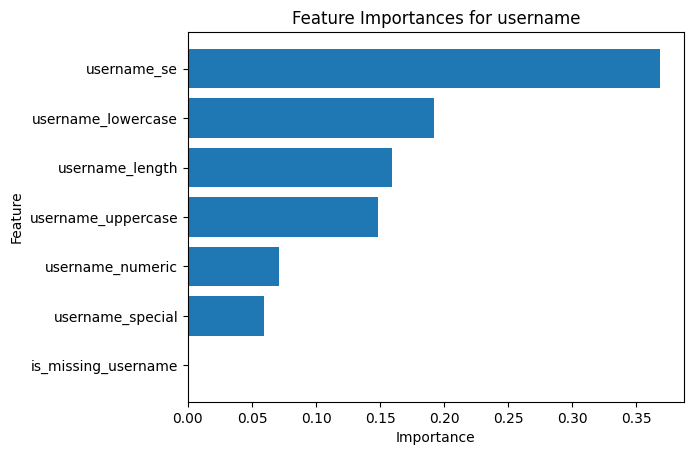

Feature Set: screenname
{'screenname_uppercase': np.float64(0.17603097514150373), 'screenname_lowercase': np.float64(0.20710167926290968), 'screenname_numeric': np.float64(0.03527805917918213), 'screenname_special': np.float64(0.11347053091691028), 'screenname_length': np.float64(0.2365975409368725), 'screenname_se': np.float64(0.23044668959237027), 'is_missing_screenname': np.float64(0.0010745249702514331)}


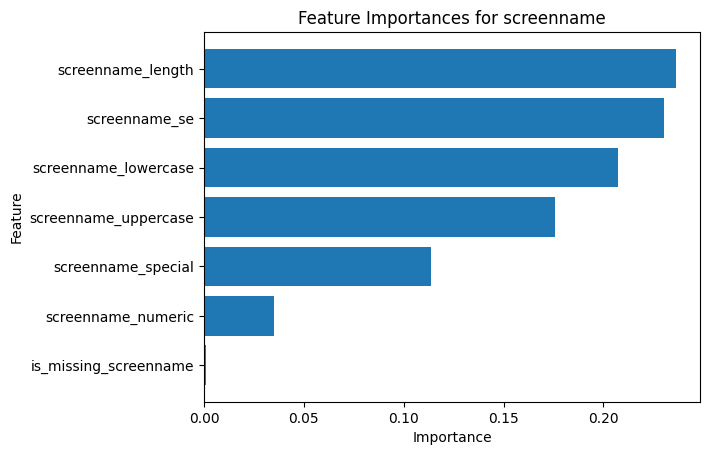

Feature Set: description
{'description_length': np.float64(0.14210367870226667), 'topic_0': np.float64(0.09207956132460574), 'topic_1': np.float64(0.07754457780683957), 'topic_2': np.float64(0.09620824104923284), 'topic_3': np.float64(0.10664118349156827), 'topic_4': np.float64(0.08486723208294025), 'topic_5': np.float64(0.09627527798041303), 'topic_6': np.float64(0.07847581677630759), 'topic_7': np.float64(0.087282315442899), 'topic_8': np.float64(0.0713406067135726), 'topic_9': np.float64(0.06495212158425996), 'is_missing_description': np.float64(0.002229387045094277)}


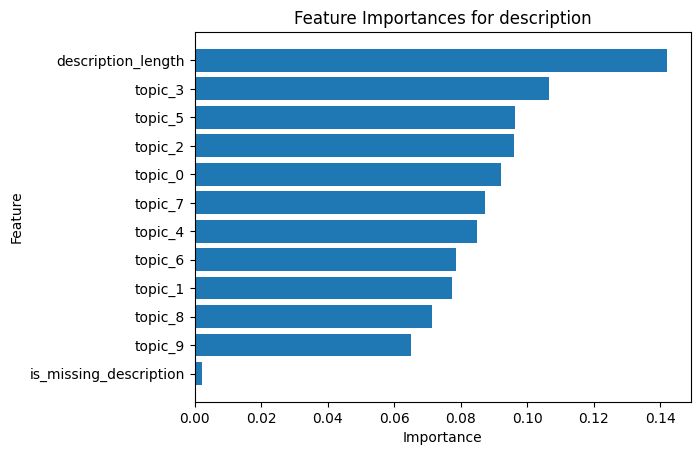

Feature Set: user_metadata
{'user_md_follower': np.float64(0.20718604703501953), 'user_md_following': np.float64(0.1543820747819608), 'user_md_follow_ratio': np.float64(0.19895893215512298), 'user_md_total_post': np.float64(0.22467486973694772), 'user_md_total_like': np.float64(0.11078943969238438), 'user_md_verified': np.float64(0.10400863659856449), 'is_missing_user_metadata': np.float64(0.0)}


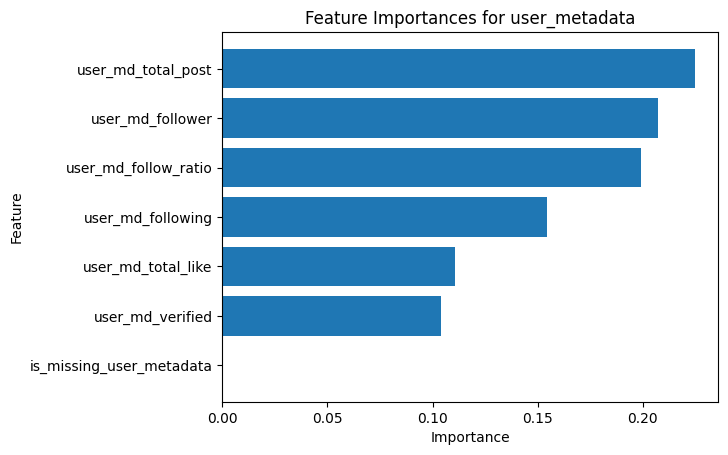

Feature Set: post
{'post_md_like_mean': np.float64(0.16483582675416478), 'post_md_like_std': np.float64(0.12470301047690294), 'post_md_retweet_mean': np.float64(0.10831200957492884), 'post_md_retweet_std': np.float64(0.08265829478189617), 'post_md_reply_mean': np.float64(0.07164422373507684), 'post_md_reply_std': np.float64(0.06680873179710589), 'is_missing_post_metadata': np.float64(0.0036697652371813615), 'post_text_length_mean': np.float64(0.06723475067295465), 'post_text_length_std': np.float64(0.04960687100857752), 'post_sentiment_score_mean': np.float64(0.05313932489785667), 'post_sentiment_score_std': np.float64(0.04773712689846885), 'post_sentiment_numeric_mean': np.float64(0.03646553293909522), 'post_sentiment_numeric_std': np.float64(0.03204967574624732), 'post_sentiment_numeric_prop_positive': np.float64(0.03058698453205822), 'post_sentiment_numeric_prop_neutral': np.float64(0.030294323605152204), 'post_sentiment_numeric_prop_negative': np.float64(0.03005067726522553), 'is_m

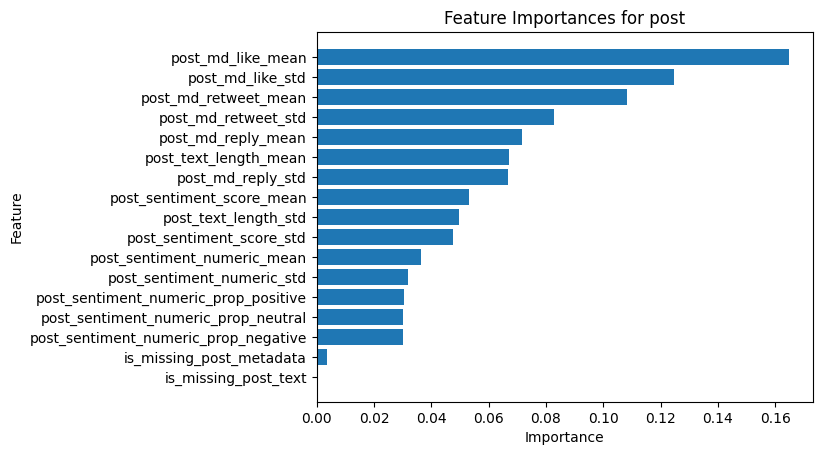

In [206]:
import matplotlib.pyplot as plt


for feature_set, models in model.items():
    print(f"Feature Set: {feature_set}")
    importances = models.feature_importances_

    # print (importances)

    feature_importance_dict = dict(zip(feature_sets_LDA[feature_set], importances))

    print (feature_importance_dict)

    # Sort and plot
    sorted_indices = np.argsort(importances)[::-1]
    plt.barh(
        np.array(feature_sets_LDA[feature_set])[sorted_indices],
        importances[sorted_indices]
    )
    plt.title(f"Feature Importances for {feature_set}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()
    plt.show()


# dataset analysis


In [207]:
df = pd.read_parquet('../data/final/testing/from/combined_testing_twibot-22_dropped.parquet')
df_2 = pd.read_parquet('../data/final/testing/combined/combined_testing_accounts_ROBERTA.parquet')

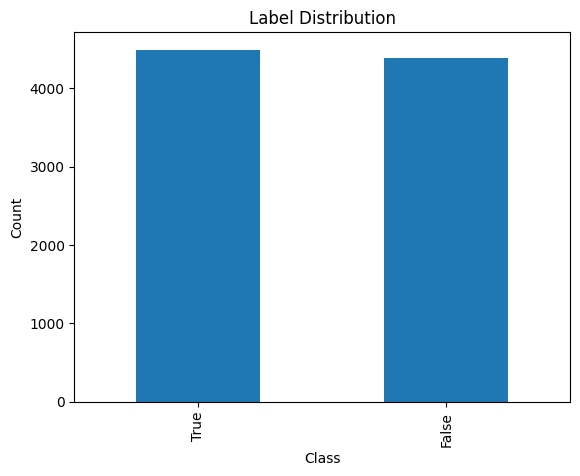

In [309]:
import matplotlib.pyplot as plt

label_counts = df_2['label'].value_counts()  # Replace 'label' with the column name
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


screenname_special                      100.000000
screenname_uppercase                    100.000000
screenname_lowercase                    100.000000
screenname_numeric                      100.000000
screenname                              100.000000
post_md_reply_std                       100.000000
post_md_reply_mean                      100.000000
post_md_quote_std                       100.000000
screenname_word                         100.000000
screenname_hashtag                      100.000000
screenname_emoji                        100.000000
screenname_se                           100.000000
screenname_length                       100.000000
post_md_quote_mean                      100.000000
user_md_protected                        80.842912
post_sentiment_numeric_mean              75.715574
post_sentiment_numeric_std               75.715574
post_sentiment_numeric_prop_positive     75.715574
post_sentiment_numeric_prop_neutral      75.715574
post_sentiment_numeric_prop_neg

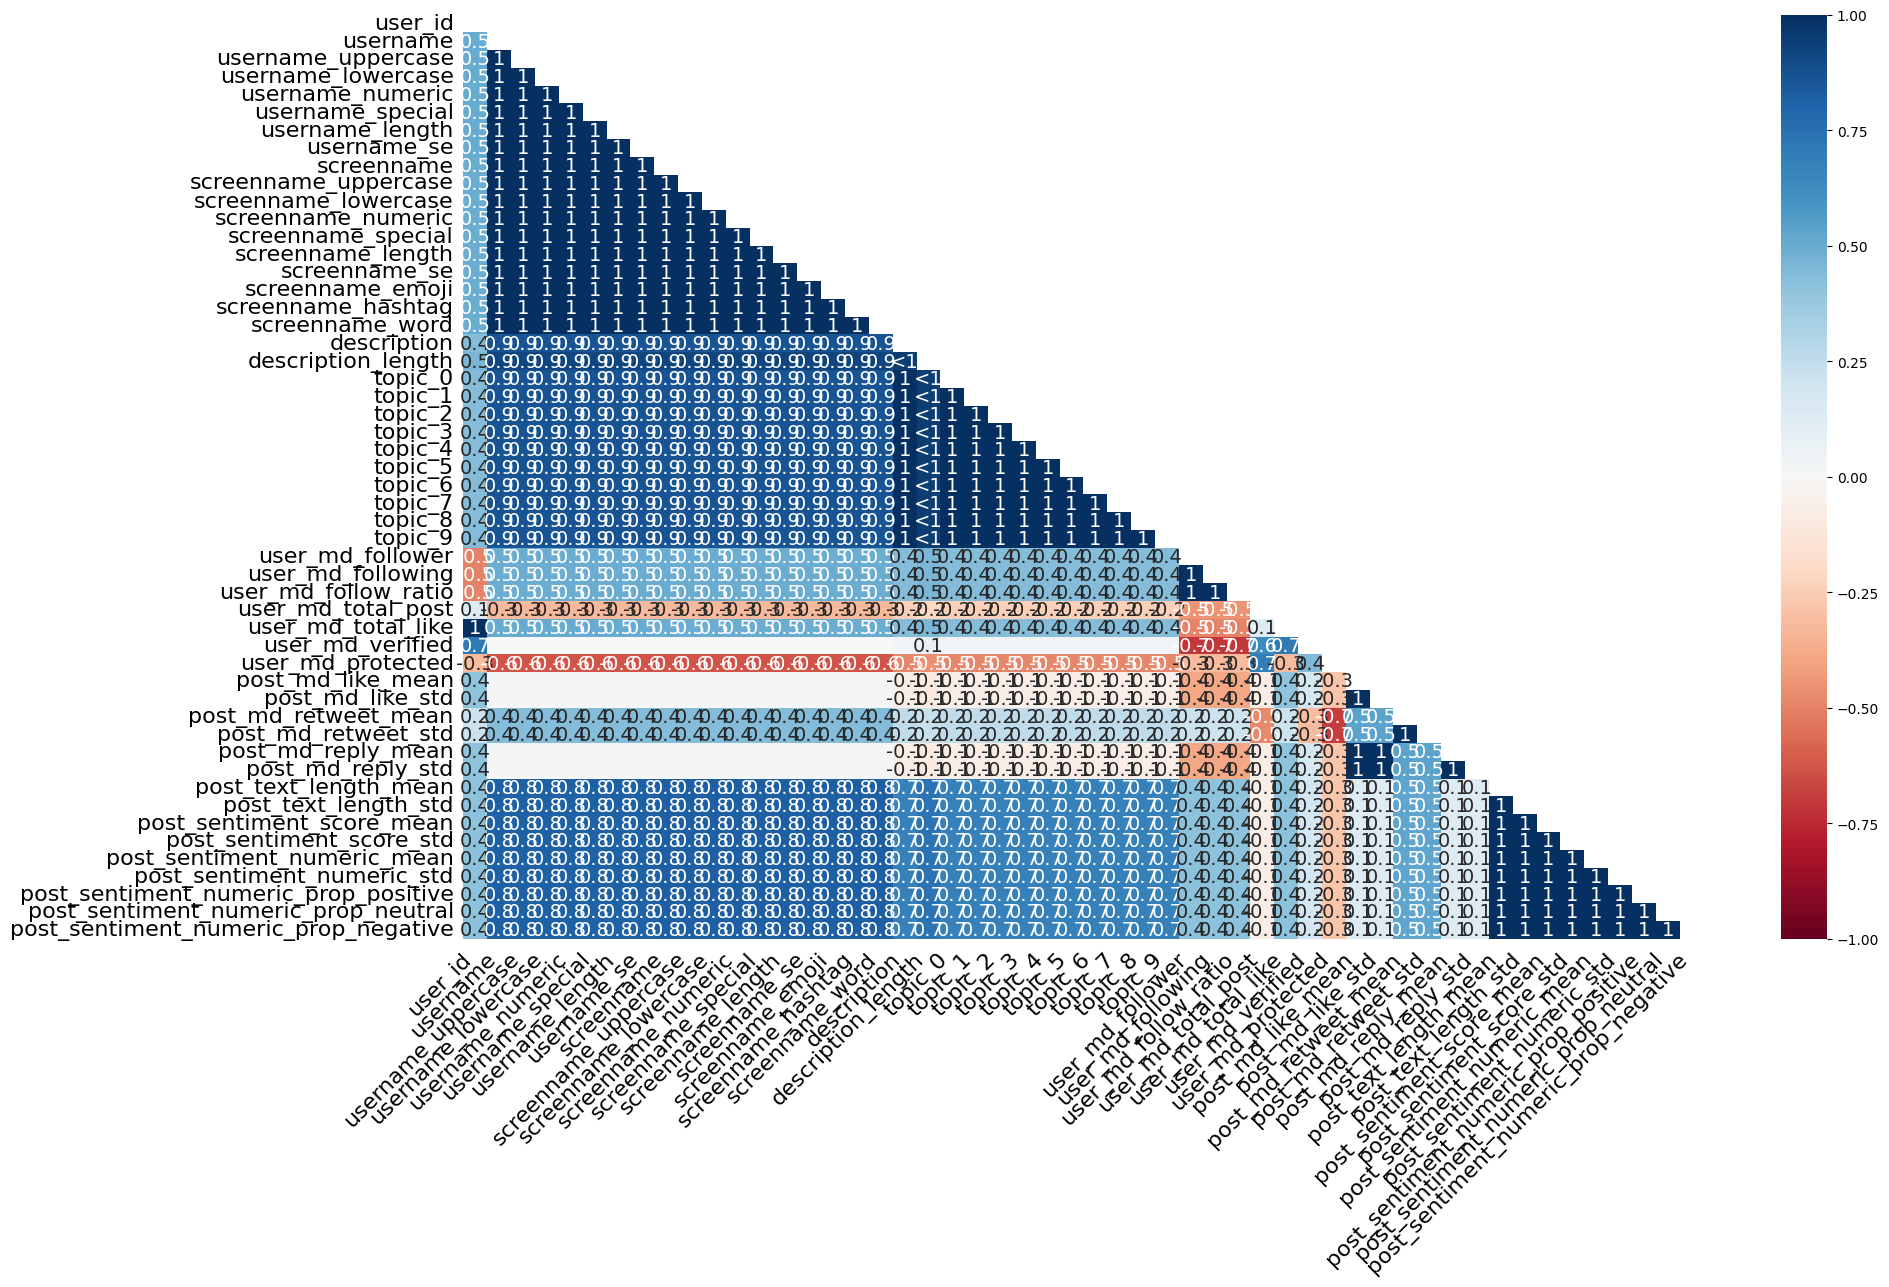

In [310]:
import missingno as msno

# Percentage of missing values
missing_percentage = df_2.isnull().mean() * 100
print(missing_percentage.sort_values(ascending=False))

# Visualize missing data
msno.heatmap(df)
plt.show()


In [215]:
import seaborn as sns

feature = 'pos_md_like_mean'

# Plot distributions for a feature across classes
sns.histplot(data=df, x=feature, hue='label', kde=True, bins=30)
plt.title('Follower Distribution by Class')
plt.show()

# sns.histplot(data=df_2, x=feature, hue='label', kde=True, bins=30)
# plt.title('Follower Distribution by Class')
# plt.show()


ValueError: Could not interpret value `pos_md_like_mean` for `x`. An entry with this name does not appear in `data`.

In [113]:
df = pd.read_parquet('../data/final/labeled/combined/combined_labeled_accounts_ROBERTA_LDA_missing.parquet')

In [114]:
from scipy.stats import ttest_ind


feature_test = 'screenname_se'
bots = df[df['label'] == True][feature_test]
humans = df[df['label'] == False][feature_test]
bots = bots.dropna()
humans = humans.dropna()
t_stat, p_value = ttest_ind(bots, humans, equal_var=False)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")


T-Statistic: 6.554545266105013, P-Value: 9.363657445270601e-11


In [116]:
from scipy.stats import ttest_ind
import pandas as pd

# Create a list to store results
results = []

# Loop through all columns to test float64/Float64 columns
for feature_test in df.select_dtypes(include=['float64', 'Float64']).columns:
    bots = df[df['label'] == True][feature_test]
    humans = df[df['label'] == False][feature_test]
    
    # Drop missing values
    bots = bots.dropna()
    humans = humans.dropna()
    
    # Perform t-test
    t_stat, p_value = ttest_ind(bots, humans, equal_var=False)
    
    # Append results to the list
    results.append({
        'Feature': feature_test,
        'T-Statistic': t_stat,
        'P-Value': p_value
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the results by P-value (ascending), the smaller P-value is more meaningful
sorted_results_df = results_df.sort_values(by='P-Value')

# Display the sorted results
print(sorted_results_df)


                                 Feature  T-Statistic        P-Value
26                      user_md_follower   -23.685349  3.556906e-110
29                    user_md_total_post   -14.051006   4.382622e-43
28                  user_md_follow_ratio   -12.621929   3.687860e-35
40                  post_text_length_std    -7.662690   9.318541e-14
11                         screenname_se     6.554545   9.363657e-11
39                 post_text_length_mean    -6.084904   2.389600e-09
27                     user_md_following    -5.977257   2.724739e-09
30                    user_md_total_like    -5.753763   1.002714e-08
10                     screenname_length     5.107145   3.887302e-07
7                   screenname_lowercase     4.751946   2.300541e-06
4                        username_length     4.060412   5.253577e-05
32                      post_md_like_std    -3.787580   1.763668e-04
36                     post_md_reply_std    -3.193725   1.519811e-03
3                       username_s

C:\Users\Vax\AppData\Local\Temp\ipykernel_2912\3367212683.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = ttest_ind(bots, humans, equal_var=False)
C:\Users\Vax\AppData\Local\Temp\ipykernel_2912\3367212683.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = ttest_ind(bots, humans, equal_var=False)


In [44]:
print(f"Bots: {bots.describe()}")
print(f"Humans: {humans.describe()}")


Bots: count       540.0
mean     3.040656
std       0.33436
min      1.685816
25%      2.863533
50%      3.085055
75%      3.251629
max      3.773557
Name: username_se, dtype: Float64
Humans: count       540.0
mean     2.978054
std      0.363997
min           1.0
25%          2.75
50%      3.022055
75%      3.238901
max      3.906891
Name: username_se, dtype: Float64


In [354]:
df = pd.read_parquet('../data/final/unlabeled/combined/combined_unlabeled_accounts_ROBERTA_LDA_missing.parquet')

# Function to calculate completeness percentage
def completeness_percentage(row):
    total_columns = len(row)
    non_missing = row.notna().sum()  # Count of non-missing values
    return (non_missing / total_columns) * 100

# Apply the function to get completeness percentage for each row
df['completeness'] = df.apply(completeness_percentage, axis=1)

# Define completeness categories (adjust as needed)
categories = {
    '0-25': (0, 25),
    '26-50': (25, 50),
    '51-75': (50, 75),
    '76-100': (75, 100)
}

# Count rows in each completeness category
category_counts = {category: df[(df['completeness'] >= bounds[0]) & (df['completeness'] <= bounds[1])].shape[0]
                   for category, bounds in categories.items()}

print(category_counts)

# # Output each category to a separate CSV
# for category, bounds in categories.items():
#     # Use .loc[] to filter and explicitly copy the filtered data
#     category_df = df.loc[(df['completeness'] >= bounds[0]) & (df['completeness'] <= bounds[1])].copy()
    
#     # Drop the 'completeness' column if not needed
#     category_df.drop(columns=['completeness'], inplace=True)
    
#     # Save to CSV
#     category_df.to_parquet(f'../data/final/labeled/combined/ROBERTA/percentage/{category}.parquet', index=False)


{'0-25': 12946, '26-50': 4343, '51-75': 4755, '76-100': 2385}


In [ ]:
file_1 = pd.read_parquet('../data/final/testing/combined/combined_testing_accounts_ROBERTA_LDA_missing_dropped.parquet')
file_2 = pd.read_parquet('../data/final/testing/from/combined_testing_twibot-22_dropped.parquet')

In [197]:
df_combined = pd.concat([file_1, file_2], ignore_index=True)

# df_combined.to_csv('../data/final/labeled/combined/ROBERTA/percentage/high_percentage.csv', index=False)
df_combined.to_parquet('../data/final/testing/combined//combined_testing_accounts_ROBERTA_LDA_missing_dropped_2.parquet', index=False)

In [171]:
# labeled_data = pd.read_parquet('../data/final/labeled/combined/ROBERTA/train_labeled_LDA_missing.parquet')
# unlabeled_data = pd.read_parquet ('../data/final/unlabeled/combined/combined_unlabeled_accounts_ROBERTA_LDA_missing.parquet')
testing_data = pd.read_parquet ('../data/final/testing/combined/combined_testing_accounts_ROBERTA_LDA_missing_dropped.parquet')

In [430]:
val_data = pd.read_parquet('../data/final/labeled/combined/ROBERTA/val_labeled_LDA_missing.parquet')

In [172]:
print (testing_data.columns)

Index(['user_id', 'username', 'username_uppercase', 'username_lowercase',
       'username_numeric', 'username_special', 'username_length',
       'username_se', 'is_missing_username', 'screenname',
       'screenname_uppercase', 'screenname_lowercase', 'screenname_numeric',
       'screenname_special', 'screenname_length', 'screenname_se',
       'screenname_emoji', 'screenname_hashtag', 'screenname_word',
       'is_missing_screenname', 'description', 'description_length', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
       'topic_7', 'topic_8', 'topic_9', 'is_missing_description',
       'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
       'user_md_total_post', 'user_md_total_like', 'user_md_verified',
       'is_missing_user_metadata', 'post_md_like_mean', 'post_md_like_std',
       'post_md_retweet_mean', 'post_md_retweet_std', 'post_md_reply_mean',
       'post_md_reply_std', 'is_missing_post_metadata',
       'post_text_l

In [164]:
# List of columns to drop
columns_to_drop = [
    'post_md_quote_mean', 
    'post_md_quote_std', 
    'user_md_protected', 
]

# Drop the specified columns from all three datasets
# labeled_data = labeled_data.drop(columns=columns_to_drop, errors='ignore')
# unlabeled_data = unlabeled_data.drop(columns=columns_to_drop, errors='ignore')
testing_data = testing_data.drop(columns=columns_to_drop, errors='ignore')


# labeled_data.to_parquet('../data/final/labeled/combined/ROBERTA/train_labeled_LDA_missing_dropped.parquet', index=False)
# unlabeled_data.to_parquet('../data/final/unlabeled/combined/combined_unlabeled_accounts_ROBERTA_LDA_missing_dropped.parquet', index=False)
testing_data.to_parquet('../data/final/testing/from/combined_testing_twibot-22_dropped.parquet', index=False)

In [432]:
val_data = val_data.drop(columns=columns_to_drop, errors='ignore')
val_data.to_parquet('../data/final/labeled/combined/ROBERTA/val_labeled_LDA_missing_dropped.parquet', index=False)

In [436]:
labeled_data = pd.read_parquet('../data/final/labeled/combined/ROBERTA/train_labeled_LDA_missing_dropped.parquet')
unlabeled_data = pd.read_parquet ('../data/final/unlabeled/combined/combined_unlabeled_accounts_ROBERTA_LDA_missing_dropped.parquet')
testing_data = pd.read_parquet ('../data/final/testing/combined/combined_testing_accounts_ROBERTA_LDA_missing_dropped.parquet')
val_data = pd.read_parquet('../data/final/labeled/combined/ROBERTA/val_labeled_LDA_missing_dropped.parquet')

In [437]:
print (labeled_data.columns)

Index(['user_id', 'username', 'username_uppercase', 'username_lowercase',
       'username_numeric', 'username_special', 'username_length',
       'username_se', 'is_missing_username', 'screenname',
       'screenname_uppercase', 'screenname_lowercase', 'screenname_numeric',
       'screenname_special', 'screenname_length', 'screenname_se',
       'screenname_emoji', 'screenname_hashtag', 'screenname_word',
       'is_missing_screenname', 'description', 'description_length', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
       'topic_7', 'topic_8', 'topic_9', 'is_missing_description',
       'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
       'user_md_total_post', 'user_md_total_like', 'user_md_verified',
       'is_missing_user_metadata', 'post_md_like_mean', 'post_md_like_std',
       'post_md_retweet_mean', 'post_md_retweet_std', 'post_md_reply_mean',
       'post_md_reply_std', 'is_missing_post_metadata',
       'post_text_l

In [ ]:
import pandas as pd
labeled_stats = labeled_data.describe()
unlabeled_stats = unlabeled_data.describe()
testing_stats = testing_data.describe()

       username_uppercase  username_lowercase  username_numeric  \
count               870.0               870.0             870.0   
mean             1.455172            9.110345          0.525287   
std              1.534322            3.104139          1.335082   
min                   0.0                 0.0               0.0   
25%                   0.0                 7.0               0.0   
50%                   2.0                10.0               0.0   
75%                   2.0                11.0               0.0   
max                  12.0                15.0              13.0   

       username_special  username_length  username_se  is_missing_username  \
count             870.0            870.0        870.0          2592.000000   
mean           0.135632        11.226437     3.006167             0.664352   
std             0.37774         2.532275       0.3516             0.472308   
min                 0.0              2.0          1.0             0.000000   
25%   

In [368]:
import pandas as pd

# Function to calculate missing data percentage for each feature in a dataset
def calculate_missing_percentage(data):
    missing_percentage = data.isnull().mean() * 100
    return missing_percentage

# Calculate missing percentages for each dataset
labeled_missing = calculate_missing_percentage(labeled_data)
unlabeled_missing = calculate_missing_percentage(unlabeled_data)
testing_missing = calculate_missing_percentage(testing_data)

# Combine missing percentages into a single DataFrame for easy comparison
missing_comparison = pd.DataFrame({
    'Labeled': labeled_missing,
    'Unlabeled': unlabeled_missing,
    'Testing': testing_missing
})

# Calculate availability (100% - missing percentage)
missing_comparison['Labeled_Available'] = 100 - missing_comparison['Labeled']
missing_comparison['Unlabeled_Available'] = 100 - missing_comparison['Unlabeled']
missing_comparison['Testing_Available'] = 100 - missing_comparison['Testing']

# Display the DataFrame for comparison
print(missing_comparison[['Labeled_Available', 'Unlabeled_Available', 'Testing_Available']])

missing_comparison.to_csv('../data/final/missing_comparison.csv', index=True)


                          Labeled_Available  Unlabeled_Available  \
description                       26.929012            31.146072   
description_length                29.398148            71.094295   
is_missing_description           100.000000           100.000000   
is_missing_post_metadata         100.000000           100.000000   
is_missing_post_text             100.000000           100.000000   
...                                     ...                  ...   
username_lowercase                33.564815            35.547147   
username_numeric                  33.564815            35.547147   
username_se                       33.564815            35.547147   
username_special                  33.564815            35.547147   
username_uppercase                33.564815            35.547147   

                          Testing_Available  
description                       43.351364  
description_length                43.351364  
is_missing_description           100.000000  

In [64]:
df_1 = pd.read_csv('../data/final/testing/from/fox-8_accounts.csv')
df_2 = pd.read_parquet('../data/final/testing/combined/combined_testing_accounts_ROBERTA_LDA_missing_dropped_2.parquet')

In [76]:
print (df_1.shape, df_2.shape)

(2280, 28) (8999, 58)


In [77]:
df_2.to_csv('../data/final/testing/combined/combined_testing_accounts_ROBERTA_LDA_missing_dropped_3.csv', index=False)
df_2.to_parquet('../data/final/testing/combined/combined_testing_accounts_ROBERTA_LDA_missing_dropped_3.parquet', index=False)

In [75]:

# Assuming df_1 and df_2 are your DataFrames
# Ensure that the 'user_id' column exists in both DataFrames
df_2 = df_2[~df_2['user_id'].isin(df_1['user_id'])]


In [74]:
common_user_ids = df_1[df_1['user_id'].isin(df_2['user_id'])]['user_id']

print (common_user_ids)

0         14214989
1        714661316
2        834585618
3        616005749
4        615051573
           ...    
2275     615131592
2276    2150773897
2277    1703075480
2278     832765820
2279     555489955
Name: user_id, Length: 2156, dtype: object


In [73]:
df_1['user_id'] = df_1['user_id'].astype(str)

print (df_1.dtypes)

user_id                  object
username                float64
username_uppercase      float64
username_lowercase      float64
username_numeric        float64
username_special        float64
username_length         float64
username_se             float64
screenname              float64
screenname_uppercase    float64
screenname_lowercase    float64
screenname_numeric      float64
screenname_special      float64
screenname_length       float64
screenname_se           float64
screenname_emoji        float64
screenname_hashtag      float64
screenname_word         float64
description             float64
description_length      float64
user_md_follower        float64
user_md_following       float64
user_md_follow_ratio    float64
user_md_total_post      float64
user_md_total_like      float64
user_md_verified        float64
user_md_protected       float64
label                      bool
dtype: object


In [69]:
common_user_ids = df_1[df_1['user_id'].isin(df_2['user_id'])]['user_id']

print (common_user_ids)

Series([], Name: user_id, dtype: int64)


In [67]:
print (df_2.shape)

(11154, 58)


In [353]:
df_2 = pd.read_parquet('../data/final/unlabeled/combined/combined_unlabeled_accounts_ROBERTA_LDA_missing_dropped.parquet')
df_1 = pd.read_parquet ('../data/final/unlabeled/combined/twibot_20.parquet')

In [354]:
combined = pd.concat([df_1, df_2], ignore_index=True)

In [355]:
combined.to_parquet('../data/final/unlabeled/combined/combined_unlabeled_accounts_ROBERTA_LDA_missing_dropped_2.parquet', index=False)

In [331]:
df.to_parquet('../data/final/labeled/combined/combined_labeled_accounts_ROBERTA_LDA_missing_2.parquet', index=False)

In [328]:
df_2.to_parquet('../data/final/unlabeled/combined/twibot_20.parquet', index=False)

In [412]:
import numpy as np
from scipy import stats

# Define the performance metrics for both models
base_model = np.array([0.62, 0.62, 0.66, 0.64, 0.24])  # Accuracy, Precision, Recall, F1 Score, MCC
ensemble_model = np.array([0.67, 0.62, 0.87, 0.73, 0.37])

# Perform the paired t-test
t_stat, p_value = stats.ttest_rel(base_model, ensemble_model)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the p-value
if p_value < 0.05:
    print("The difference between the models is statistically significant (reject null hypothesis).")
else:
    print("The difference between the models is not statistically significant (fail to reject null hypothesis).")


T-statistic: -2.687484052588101
P-value: 0.05480095793714684
The difference between the models is not statistically significant (fail to reject null hypothesis).
